## Ecommerce Trade Sales

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pytrends.request import TrendReq
from statsmodels.tsa.stattools import kpss, adfuller
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import pearsonr
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

## Reading and Filtering StatsCanada Ecommerce data

In [2]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')
data.head(2)

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0


In [3]:
# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])

# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})

In [4]:
retailEcommercesales.head(2)

,Date,Ecommerce_sales
3,2016-01,977198
7,2016-02,1006610


In [184]:
retailEcommercesales.shape

(74, 1)

**Time series plot of Ecommerce trade sales**

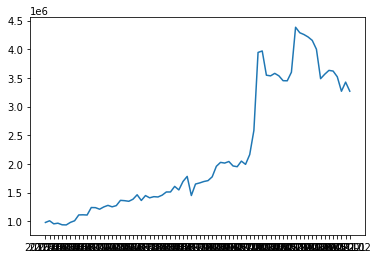

In [5]:
retailEcommercesales_dup = retailEcommercesales.copy()
retailEcommercesales_dup.index = retailEcommercesales_dup['Date']
plt.plot(retailEcommercesales_dup['Ecommerce_sales'])
plt.show()

In [4]:
retailEcommercesales_ts = retailEcommercesales.set_index('Date')

In [8]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales
Date,
2016-01,977198
2016-02,1006610


**Growth Rate of Ecommerce Retail Sales**

In [5]:
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()
retailEcommercesales_ts = retailEcommercesales_ts.dropna() # removing NA
retailEcommercesales_ts.index = pd.to_datetime(retailEcommercesales_ts[['Growth_rate']].index)
#plt.plot(retailEcommercesales_ts['Growth_rate'])
#plt.show()

In [9]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales,Growth_rate
Date,,
2016-02-01,1006610,0.030098
2016-03-01,953186,-0.053073


**Time series for growth rate**

In [6]:
def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=100, width = 16, height = 5):
    plt.figure(figsize=(width,height), dpi=dpi)
    plt.plot(y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

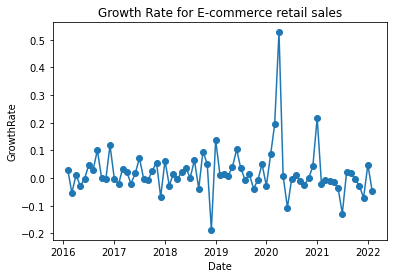

<Figure size 1600x500 with 0 Axes>

In [11]:
# Plot

plt.plot(retailEcommercesales_ts['Growth_rate'], marker = 'o')

# Labelling
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for E-commerce retail sales")
plt.figure(figsize = (16,5), dpi = 100)

# Display
plt.show()

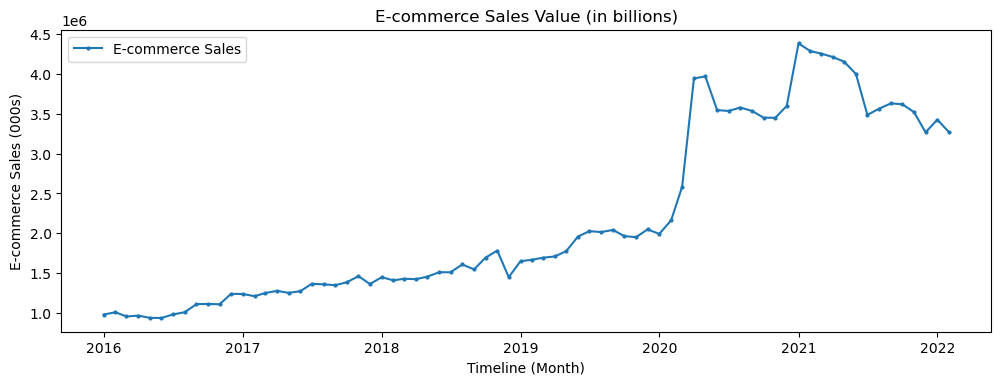

In [120]:
#### Retail sales Plot for presentation
plot_data = retailEcommercesales['Ecommerce_sales']
plot_data.index = pd.to_datetime(plot_data.index)
fig = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(plot_data, marker='o', markersize=2, label="E-commerce Sales")
plt.gca().set(title="E-commerce Sales Value (in billions)", xlabel="Timeline (Month)", ylabel="E-commerce Sales (000s)")
plt.xticks()
plt.legend()
plt.savefig('ecommerce_value.png')
plt.show()

### Stationarity Statistical test

**KPSS and ADF Test**

In [7]:
def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"
        
def check_stationarity(dataframe):
    for i in range(0,dataframe.shape[1]):
        timeseries = dataframe.iloc[:,i]
        adf_result = adf_test(timeseries)
        kpss_result = kpss_test(timeseries)
        if (adf_result == "Series is stationary") and (kpss_result == "Series is stationary"):
            pass
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary")
        elif (adf_result == "Series is stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary, differencing can be used to make it stationary")
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is stationary"):
            print(f"Series {dataframe.columns[i]} is trend stationary, trend needs to be removed")
    print("All other series are stationary")

**Testing the ecommerce sale\'s series stationarity**

In [8]:
kpss_test(retailEcommercesales_ts['Growth_rate'])
adf_test(retailEcommercesales_ts['Growth_rate'])

'Series is stationary'

## Keywords extraction using PyTrend

In [115]:
pytrends = TrendReq(hl = 'en-us', backoff_factor = 0.1)

def ecommerce_trend(keywords = [''],category = '340'):  #subcat - 280
    
    """ 
    Function for getting trends for selected keywords
        
        arguments: 
        
            Keywords: List of String ser
            category: String: stores the code for category
        
        returns: Related queries and related topics from google trend as a data frame
    """
    kw_list = keywords
    cat = category
    timeframe = '2004-01-01 2022-05-11'
    geo = 'CA'
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop = '')
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    
    return data, queries, topics

In [15]:
data2, queries2, topics2 = ecommerce_trend(keywords = ['Doordash'],category = '340')

In [16]:
data2.tail()

,Doordash,isPartial
date,,
2022-01-01,100,False
2022-02-01,98,False
2022-03-01,56,False
2022-04-01,87,False
2022-05-01,70,True


**Extracting time series from manually extracted keywords**

In [116]:
keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic

keywords_csv = pd.read_csv('../../data/keywords_data/ECOMMERCE.csv')

In [117]:
for index, row in keywords_csv.iterrows():
    #print(([row['Keyword']]))
    data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
    
    if index==0:
        FinalData, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        FinalData.rename(columns = {'':str(row['Keyword'])}, inplace = True)    #column name for frame
        FinalData=FinalData.drop(columns=['isPartial'])   #remove column
    else:
        data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        data.rename(columns = {'':str(row['Keyword'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['Keyword'])]
        FinalData = FinalData.join(data)

In [118]:
FinalData

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,Amazon,newegg canada,ebay,...,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,google,Google Pay,Apple Pay,Mastercard,SquareSpace
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,0,57,...,53,39,0,0,80,0,0,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,0,12,...,48,46,46,0,0,0,0,0,0,0
2004-03-01,0,0,0,0,0,0,0,0,0,29,...,42,22,56,0,100,0,0,0,100,0
2004-04-01,0,0,0,0,0,0,0,0,0,23,...,44,48,23,0,0,5,0,0,40,0
2004-05-01,0,0,0,0,0,0,0,13,0,61,...,48,37,20,0,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,86,100,77,56,41,0,19,73,0,28,...,53,71,30,81,46,47,87,56,58,48
2022-02-01,81,97,21,80,34,0,28,67,0,20,...,51,71,35,76,14,44,77,57,45,46
2022-03-01,82,61,57,84,100,0,19,73,44,23,...,48,69,28,82,25,48,85,60,78,20


In [119]:
#keywords exported as CSV with revelant time series
FinalData.to_csv('EcommerceKeywordTimeSeries.csv')

**Extracting Queries and related topics time series**

In [120]:
category_ts, queries, topics = ecommerce_trend(keywords = [''],category = '340')  #function calling

keyword_query_frame = dict()  #Dictionary for queries
keyword_topic_frame = dict()  #Dictionary for topic

# keywords from queries
keyword_rising_query = queries['']['rising']['query'].unique().tolist() 
keyword_top_query = queries['']['top']['query'].unique().tolist()

# keywords from topic
keyword_rising_topics = topics['']['rising']['topic_title'].unique().tolist() 
keyword_top_topics = topics['']['top']['topic_title'].unique().tolist()

In [121]:
# keywords dict
keyword_query_frame['340'] = keyword_top_query
keyword_topic_frame['340'] = keyword_top_topics

In [122]:
# keywords from google trend query and topics
keyword_topic_frame

{'340': ['PayPal',
  'Payment',
  'Money',
  'Canada',
  'Shopify',
  'Number',
  'Bank',
  'Western Union',
  'MoneyGram International Inc',
  'PayPal CA ltd',
  'Account',
  'Invoice',
  'Moneris',
  'Credit',
  'TD Canada Trust',
  'Credit card',
  'E-commerce',
  'Cheque',
  'Google',
  'Electronic funds transfer',
  'Routing number']}

## Evaluating Category\'s time series

In [123]:
category_ts = category_ts.drop(columns = 'isPartial')
category_ts['Growth_rate'] = category_ts.pct_change()
category_ts = category_ts.dropna()

In [124]:
category_ts.head(2)

,,Growth_rate
date,,
2004-02-01,93,0.033333
2004-03-01,81,-0.129032


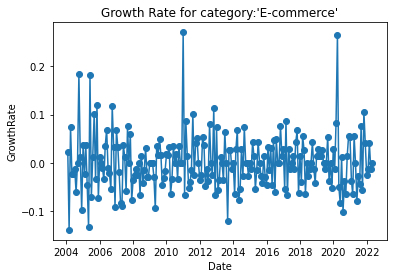

<Figure size 1600x500 with 0 Axes>

In [28]:
# Plot
plt.plot(category_ts['Growth_rate'], marker = 'o')

# Labelling 
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for category:'E-commerce'")
plt.figure(figsize = (16,5), dpi = 100)

# Display
plt.show()

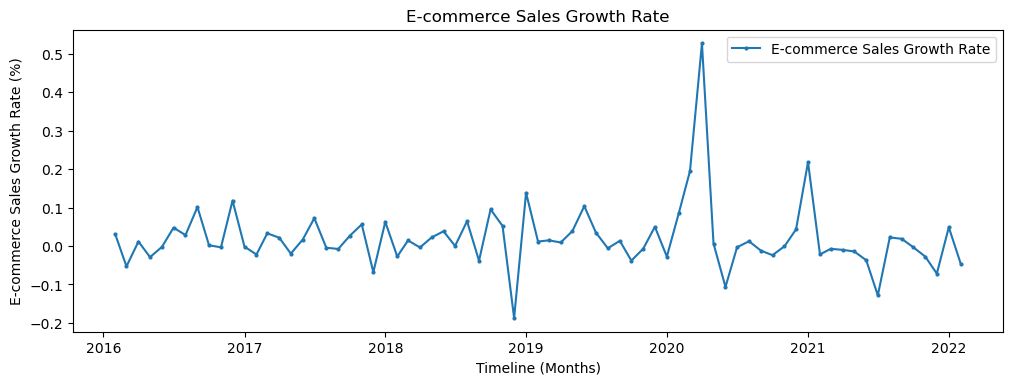

In [125]:
plot_data = retailEcommercesales_ts['Growth_rate']
plot_data.index = pd.to_datetime(plot_data.index)
fig = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(plot_data, marker='o', markersize=2, label="E-commerce Sales Growth Rate")
plt.gca().set(title="E-commerce Sales Growth Rate", xlabel="Timeline (Months)", ylabel="E-commerce Sales Growth Rate (%)")
plt.xticks()
plt.legend()
plt.savefig("ecommerce_growthrate.png")
plt.show()

**Category time series stationarity testing**

In [29]:
kpss_test(category_ts['Growth_rate'])

'Series is stationary'

In [30]:
adf_test(category_ts['Growth_rate'])

'Series is stationary'

### Wrangling manually extracted Keywords in EcommerceKeywordTimeSeries.csv

In [9]:
ecommerce_keyword_ts = pd.read_csv('EcommerceKeywordTimeSeries.csv')
ecommerce_keyword_ts.rename(columns = {'date':'Date'}, inplace = True)
ecommerce_keyword_ts = ecommerce_keyword_ts.set_index(['Date'])
ecommerce_keyword_ts.index = pd.to_datetime(ecommerce_keyword_ts.index)
ecommerce_keyword_ts = ecommerce_keyword_ts.dropna()

In [127]:
ecommerce_keyword_ts.head(2)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,Amazon,newegg canada,ebay,...,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,google,Google Pay,Apple Pay,Mastercard,SquareSpace
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,0,57,...,53,39,0,0,80,0,0,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,0,12,...,48,46,46,0,0,0,0,0,0,0


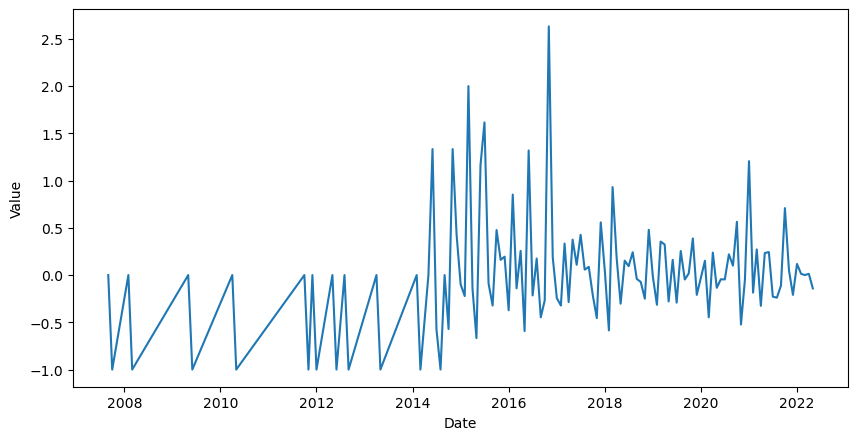

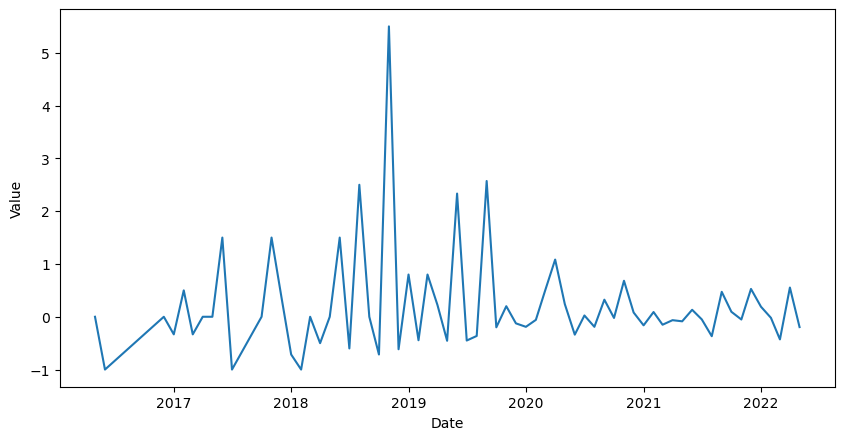

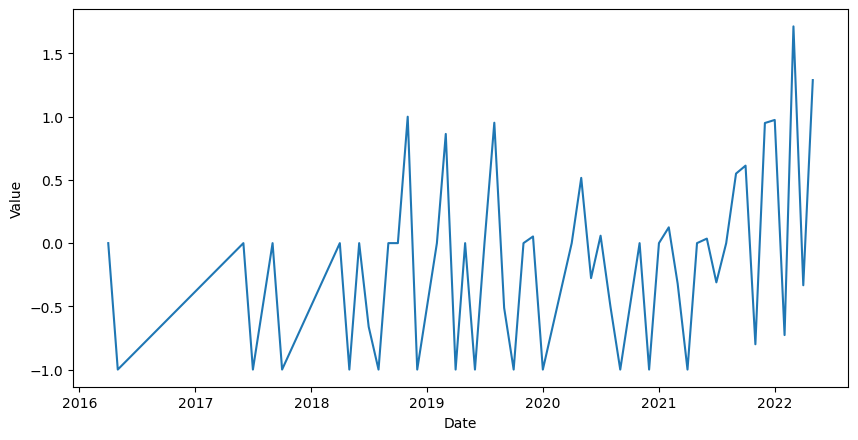

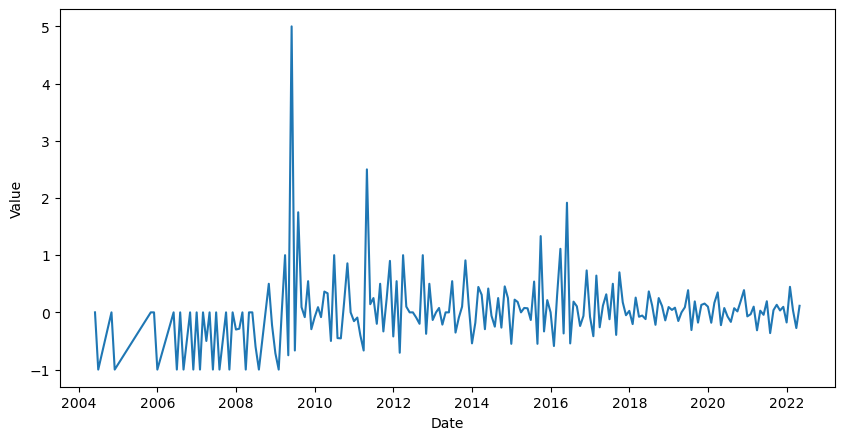

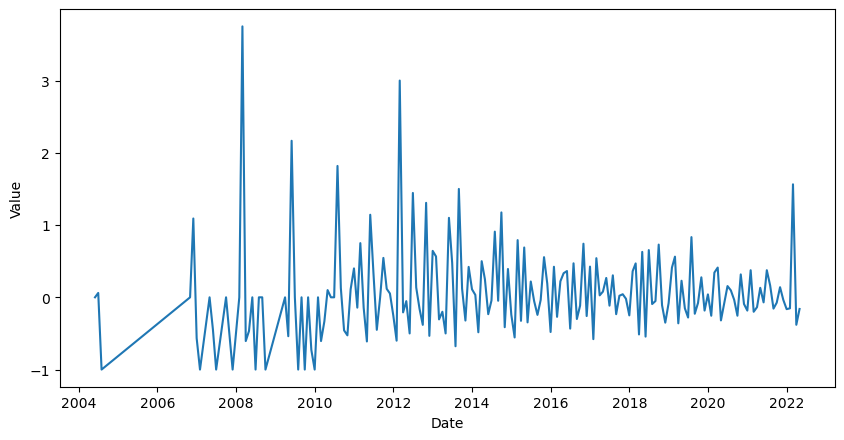

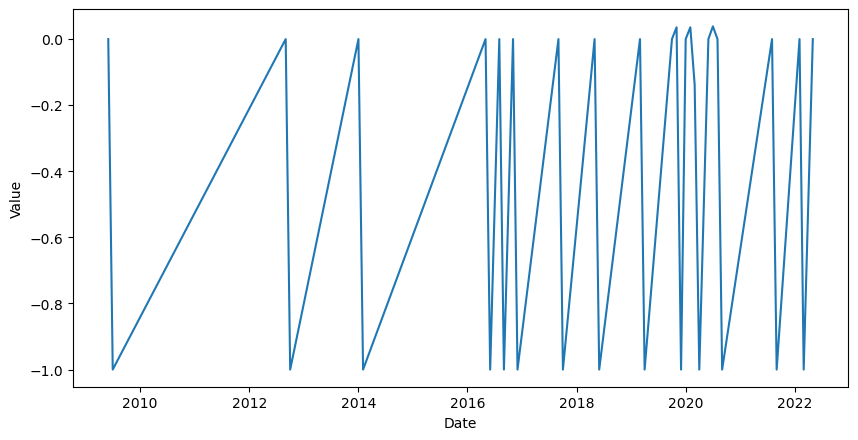

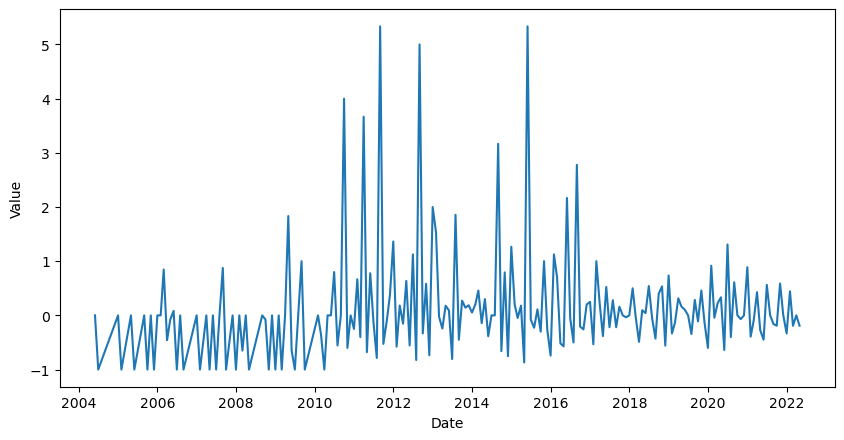

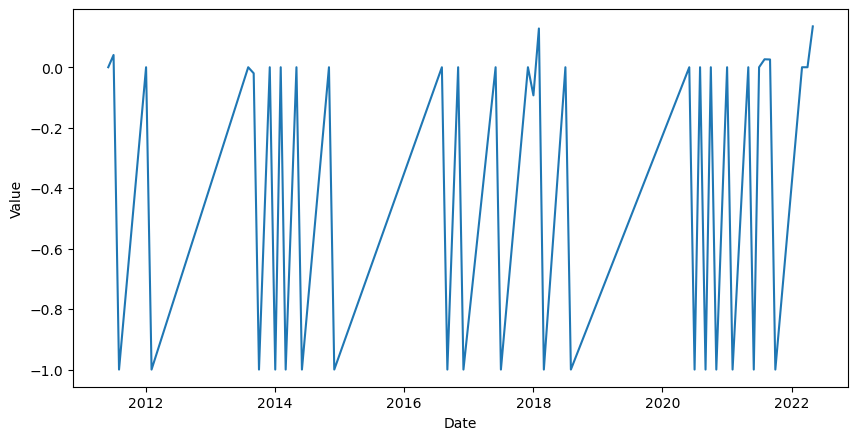

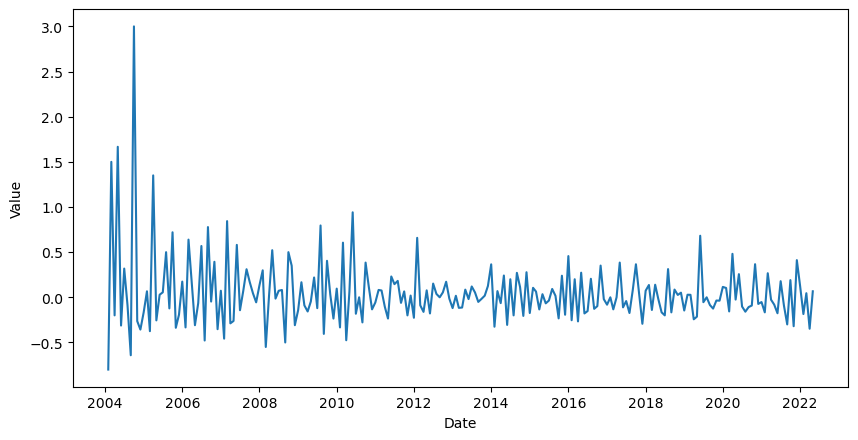

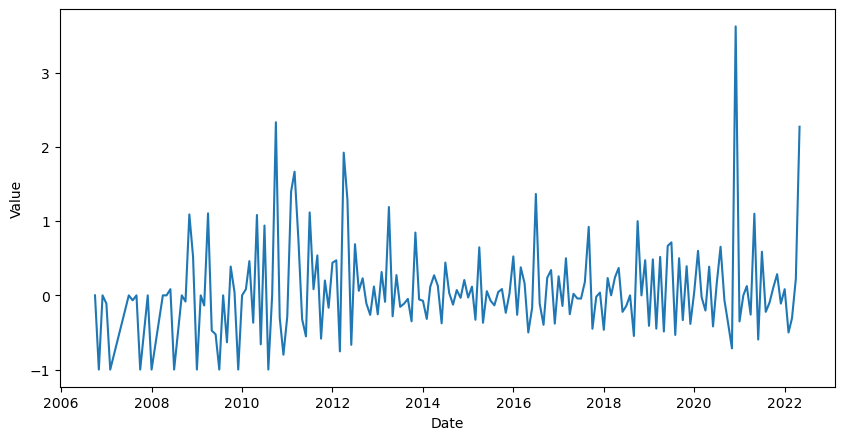

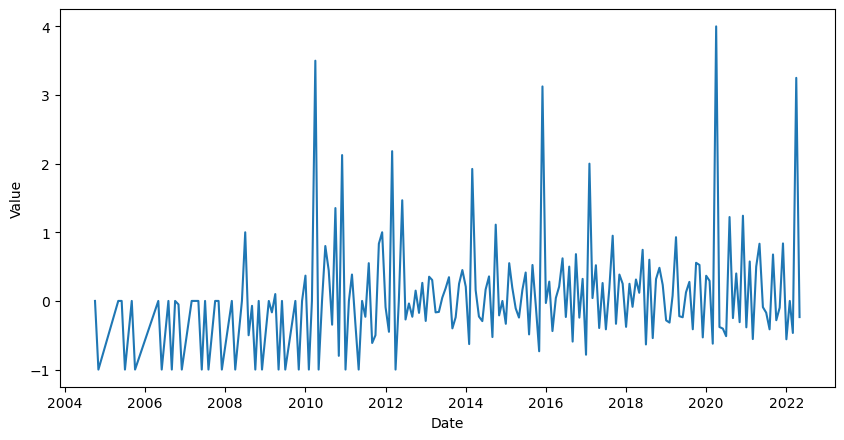

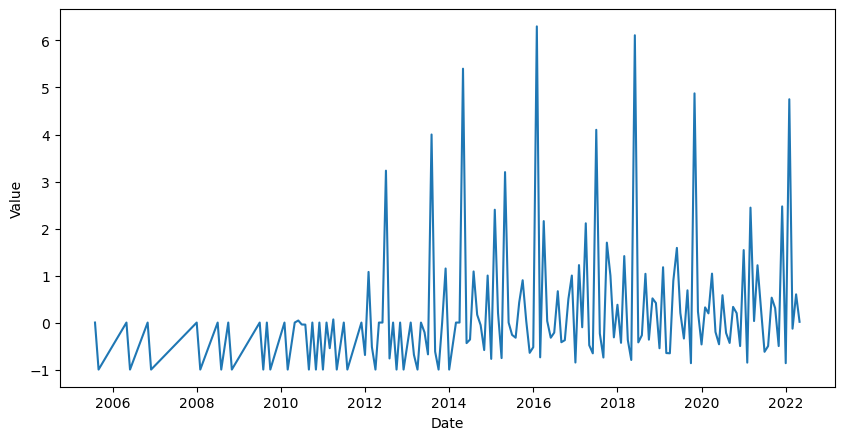

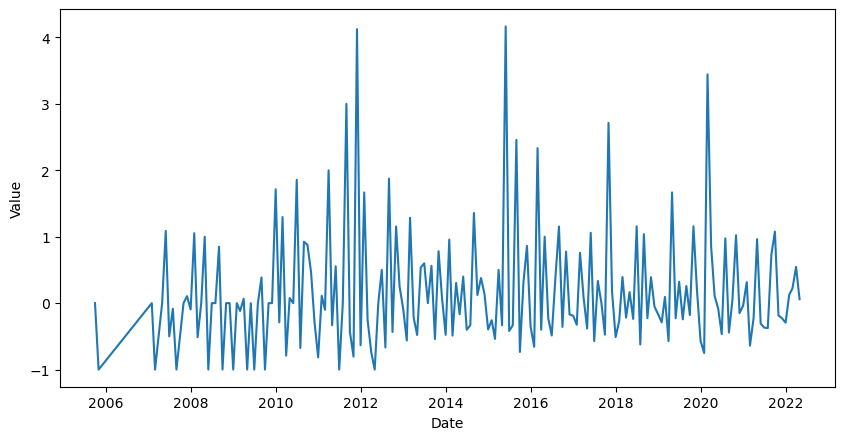

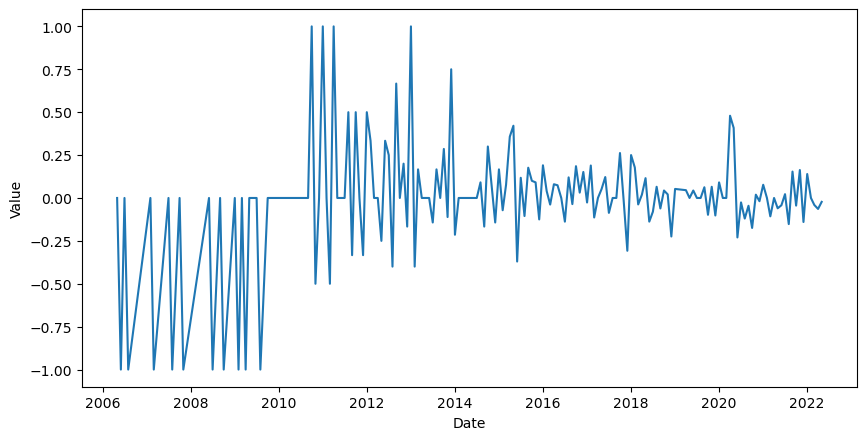

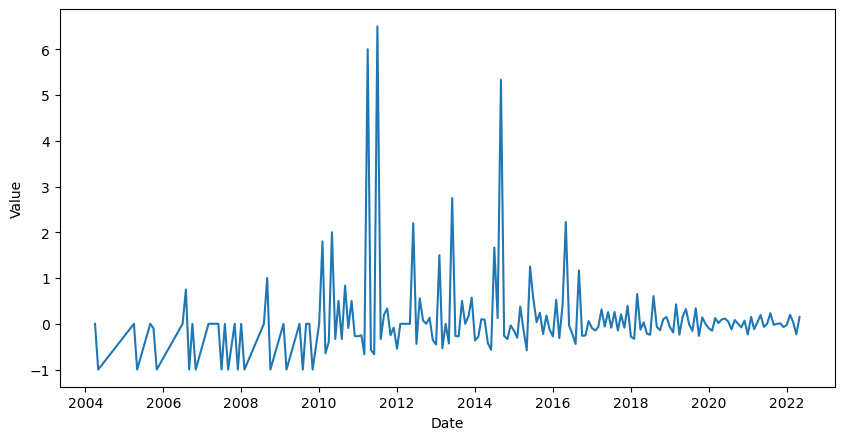

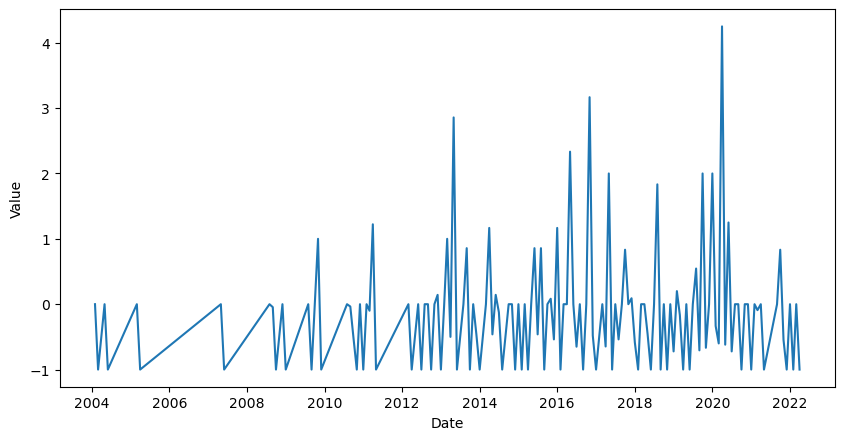

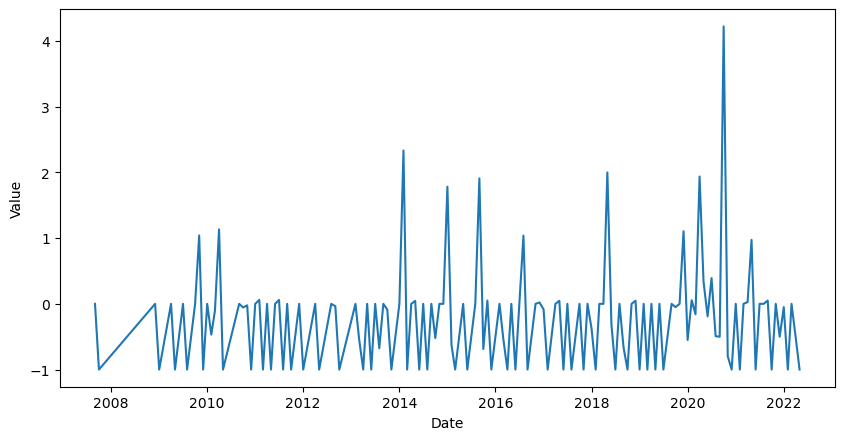

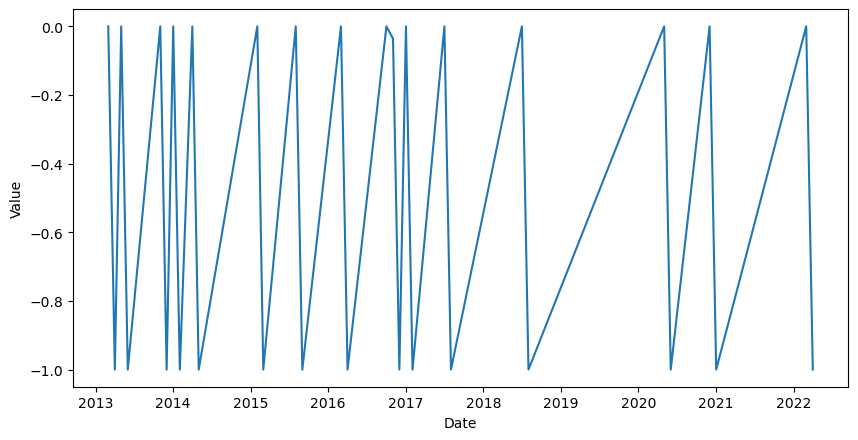

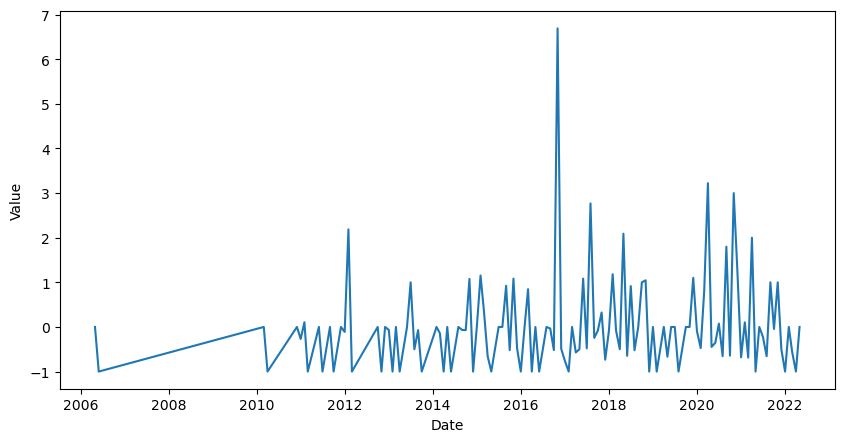

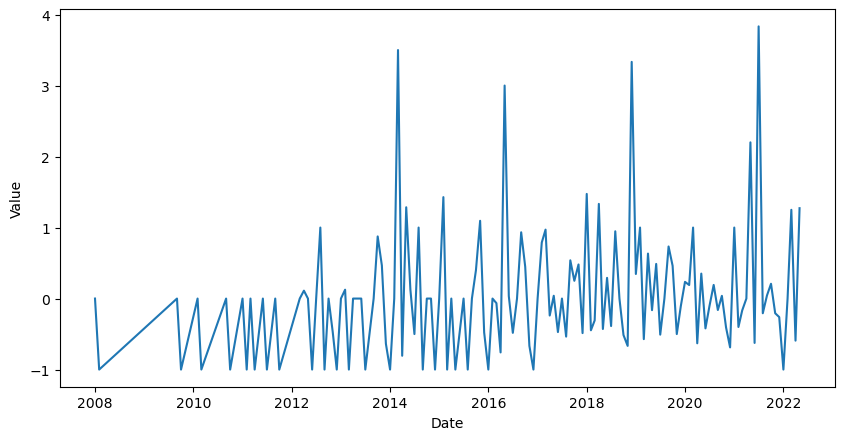

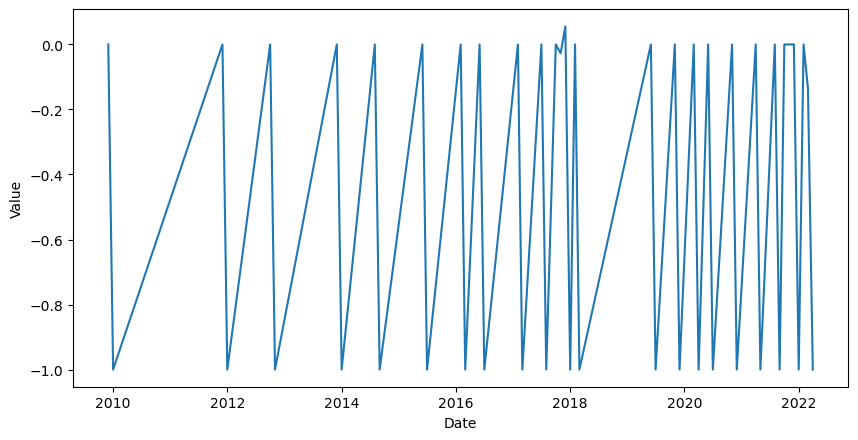

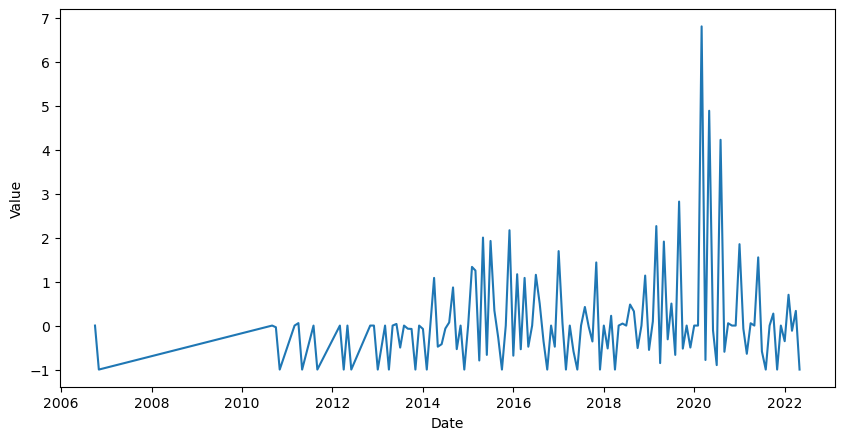

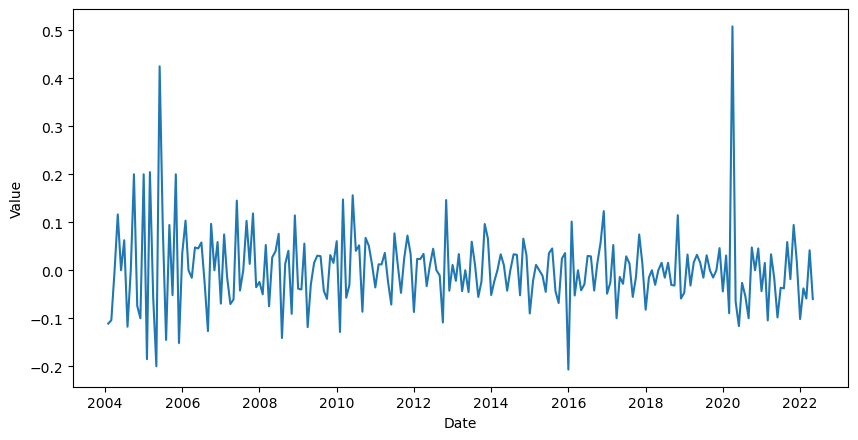

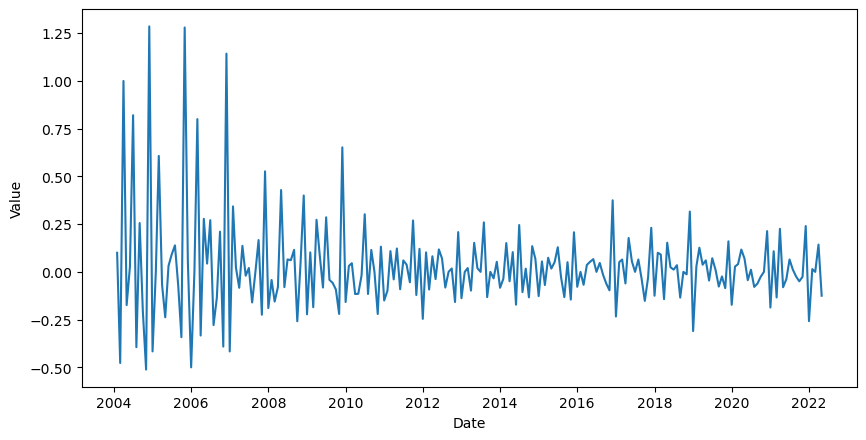

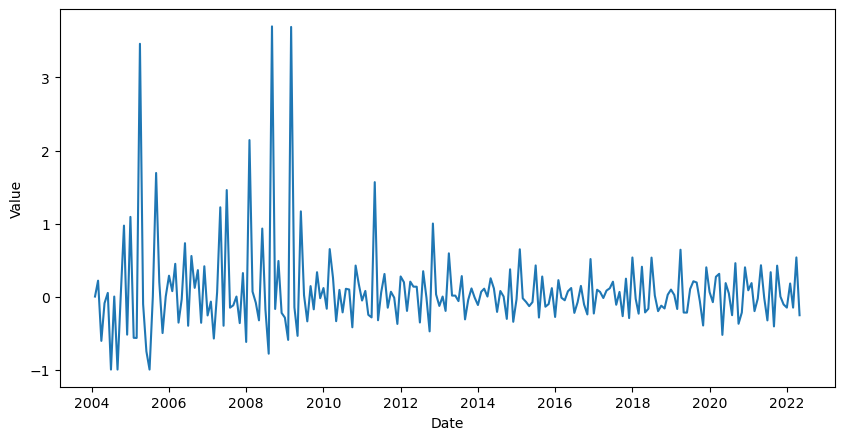

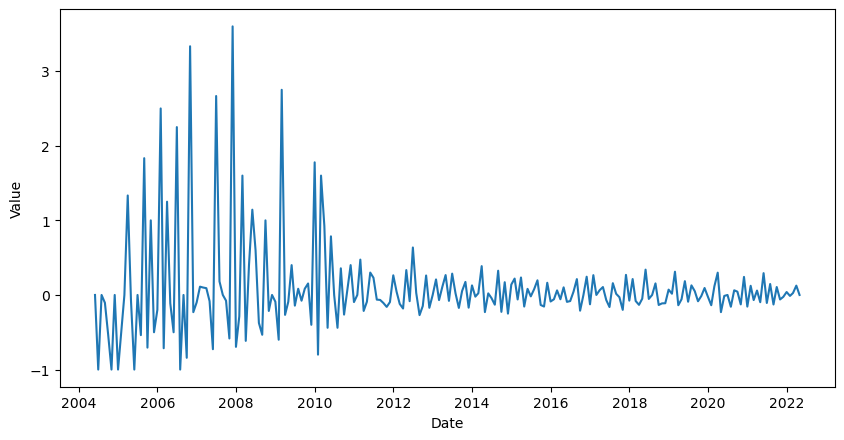

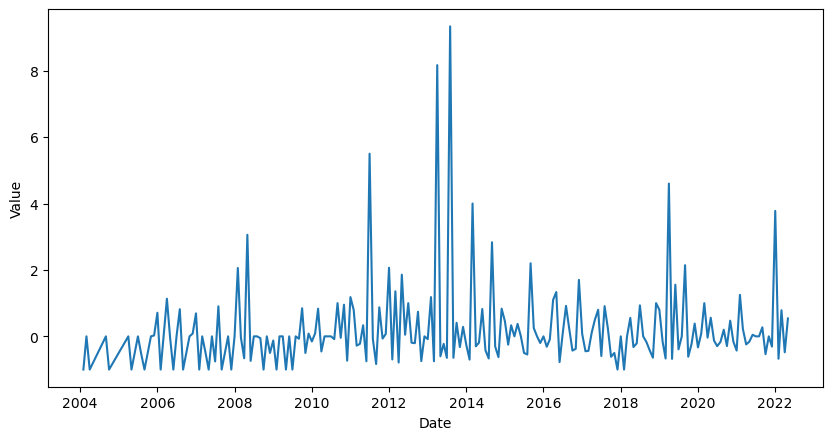

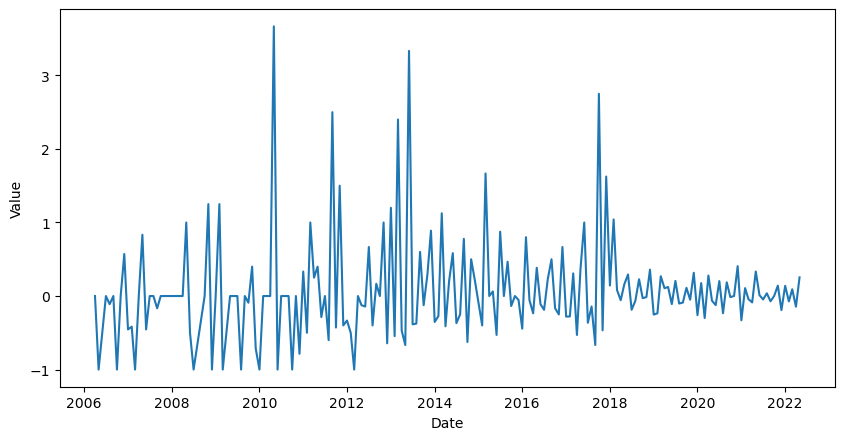

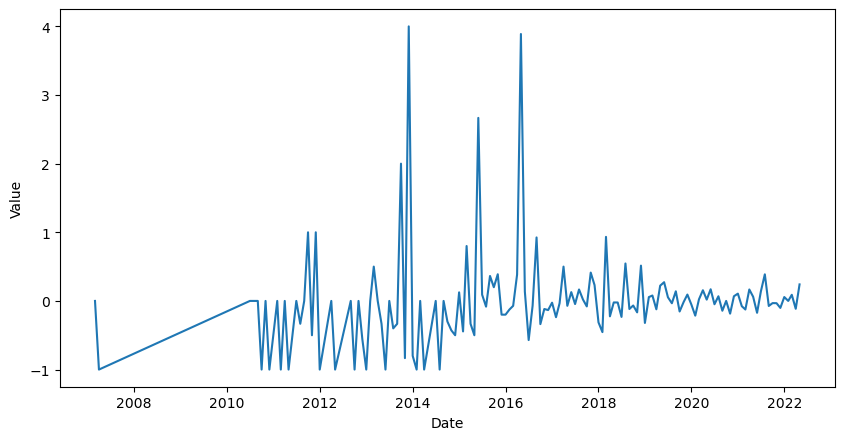

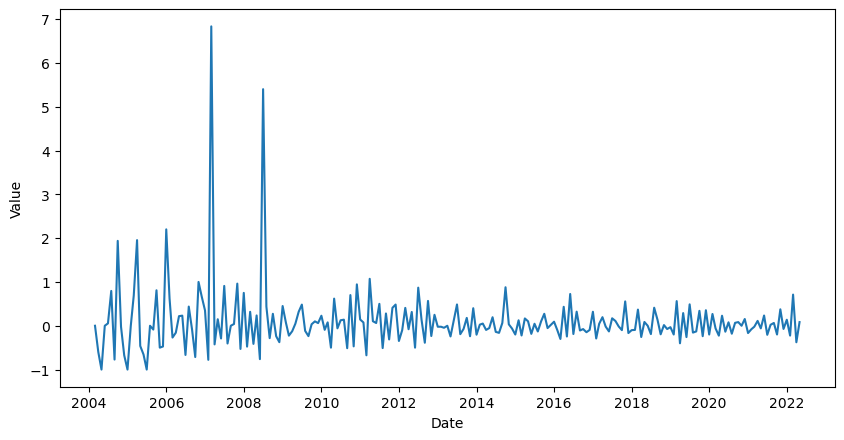

In [34]:
for column in ecommerce_keyword_ts:
    df = pd.DataFrame()
    df['Growth_rate'] = ecommerce_keyword_ts[column].pct_change()
    df = df.dropna()
    df.replace([np.inf, -np.inf], 0, inplace=True)
    plot_df(df,width=10)
    adf_test(df['Growth_rate'])
    kpss_test(df['Growth_rate'])


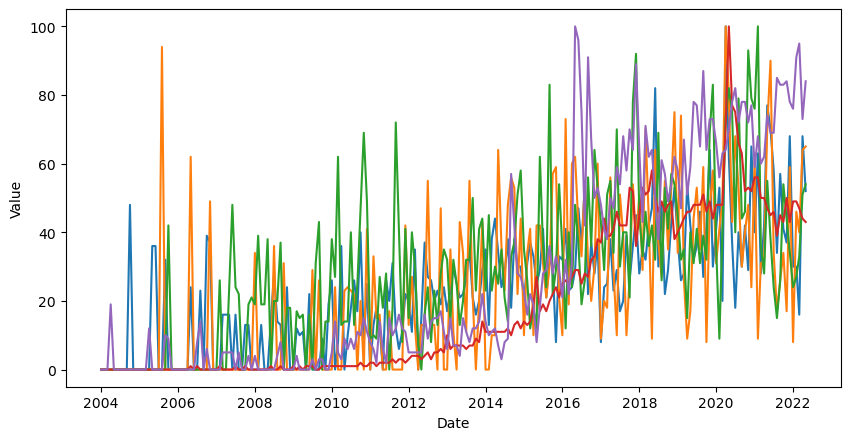

In [35]:
plot_df(ecommerce_keyword_ts[ecommerce_keyword_ts.columns[10:15]], width = 10)

In [130]:
# get dataframe of timeseries for categories

cat_queries_dict = {}
cat_topics_dict = {}

def cat_dict():

    # get time series and related queries and topics of categories
    for i, category in enumerate(cat_lst):
        category = str(category)
        data, queries, topics = get_trends(category=category, related_queries=2, related_topics=2)
        cat_queries_dict[category] = queries
        cat_topics_dict[category] = topics

        #Code to append data for different columns in data frame
        if i == 0:
            data.rename(columns = {'': category}, inplace = True)
            categoryts = data.drop(columns=['isPartial'])
        else:
            data.rename(columns = {'': category}, inplace = True)
            data = data.drop(columns=['isPartial'])
            categoryts = categoryts.join(data)

###  Trend removal

#### Extracting and removing trend

In [10]:
def get_long_term_trend(dataframe, freq='M'):
    """extract the monthly trend from the series"""
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe, gdp_categoryts_df, freq = 'M'):
    """pass dataframe to remove bias and downward trend"""
    trend_data = get_long_term_trend(gdp_categoryts_df, freq)
    log_category = np.log(dataframe)
    log_category.replace([np.inf, -np.inf], 0, inplace=True)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())
    
    # remove long term bias
    transformed_data = log_category - rescaled_component.values
    transformed_data.index = pd.to_datetime(transformed_data.index)

    return transformed_data

In [11]:
def make_predictors_df(*arg):
    """joins the predictors dataframes"""
    if len(arg) > 1:
        for i in range(0, len(arg)-1):
            if i == 0:
                arg[i].index = pd.to_datetime(arg[i].index)
                arg[i+1].index = pd.to_datetime(arg[i+1].index)
                predictors_df = pd.merge(arg[i], arg[i+1], left_index=True, right_index=True)
            else:
                predictors_df = pd.merge(predictors_df, arg[i+1], left_index=True, right_index=True)
    else:
        arg[0].index = pd.to_datetime(arg[0].index)
        return arg[0]
    return predictors_df

### Normalize data

In [12]:
def normalize(dataframe):
    """function to normalize dataframe"""
    data = dataframe.copy()
    scaler = StandardScaler()
    scaler.fit(dataframe)
    scaled_df = pd.DataFrame(scaler.transform(dataframe))
    scaled_df.index = data.index
    scaled_df.columns = data.columns
    return scaled_df

# difference
def detrend(dataframe):
    """function to detrend time series"""
    return dataframe.diff().dropna()

# seasonality
def remove_seasonality(dataframe):
    """function for differencing of time series"""
    data = dataframe.copy()
    # monthly mean
    mean_data = dataframe.groupby(dataframe.index.month).mean()
    
    for i, d in enumerate(data.index):
        data.iloc[i,:] = mean_data.loc[d.month]
    removed_seaonality_data = dataframe - data
    return removed_seaonality_data

# cyclicity 
def remove_volatility(dataframe):
    """function for removing volatility of time series"""
    data = dataframe.copy()
    # monthly mean
    std_data = dataframe.groupby(dataframe.index.year).std()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = std_data.loc[d.year]
    removed_vol_data = dataframe - data
    return removed_vol_data

In [13]:
normalized_ecommerce_keyword = normalize(ecommerce_keyword_ts)
detrend_ecommerce_keyword = (detrend(normalized_ecommerce_keyword))
check_stationarity(detrend_ecommerce_keyword)

Series DoorDash is trend stationary, trend needs to be removed
Series Joe Fresh is not stationary, differencing can be used to make it stationary
Series mto e-commerce is trend stationary, trend needs to be removed
Series google is not stationary, differencing can be used to make it stationary
Series SquareSpace is not stationary, differencing can be used to make it stationary
All other series are stationary


In [14]:
predictor = make_predictors_df(detrend_ecommerce_keyword)
response = make_predictors_df(retailEcommercesales_ts[['Growth_rate']])

In [133]:
detrend_ecommerce_keyword.head(3)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,Amazon,newegg canada,ebay,...,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,google,Google Pay,Apple Pay,Mastercard,SquareSpace
Date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.035398,...,-0.373158,0.446819,2.397787,0.0,-4.492664,0.000000,0.0,0.0,0.000000,0.0
2004-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.146706,...,-0.447789,-1.531951,0.521258,0.0,5.615830,0.000000,0.0,0.0,5.795586,0.0
2004-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.404720,...,0.149263,1.659614,-1.720151,0.0,-5.615830,0.314946,0.0,0.0,-3.477352,0.0


### Split dataset into train, validation, test dataset

In [15]:
def ts_train_test_split(response, predictor, test_size):
    " splits the train and test set and also returns the extra test data of predictors"
    # train test split
    joind_df = pd.merge(response, predictor, left_index=True, right_index=True)
    train, test = train_test_split(joind_df, test_size=test_size, shuffle=False)
    # extra test data
    extra_test_data = predictor.loc[predictor.index > joind_df.index[len(joind_df.index)-1], :]
    return train, test, extra_test_data

In [16]:
train_df, test_df, extra_df = ts_train_test_split(retailEcommercesales_ts[['Growth_rate']],detrend_ecommerce_keyword, 0.2)

In [135]:
extra_df

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,Amazon,newegg canada,ebay,...,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,google,Google Pay,Apple Pay,Mastercard,SquareSpace
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-01,0.031184,-1.788042,1.954862,0.172859,3.259374,0.000000,-0.596374,0.226109,2.154872,0.20236,...,-0.223895,-0.127663,-0.364881,0.231362,0.617741,0.251957,0.273529,0.123007,1.912543,-1.132444
2022-04-01,0.062368,1.291364,-1.031733,-1.123585,-2.222300,0.000000,0.331319,-0.263793,0.000000,-0.40472,...,0.074632,0.638313,0.938264,0.192802,-0.449266,-0.440924,-0.512867,-0.287016,-1.854588,0.000000
2022-05-01,0.031184,-1.092693,2.063466,0.216074,-0.296307,2.380178,-0.066264,-0.678326,0.000000,-0.20236,...,-0.149263,-0.638313,-0.573384,0.192802,0.224633,0.314946,0.478676,0.410023,0.173868,-0.566222


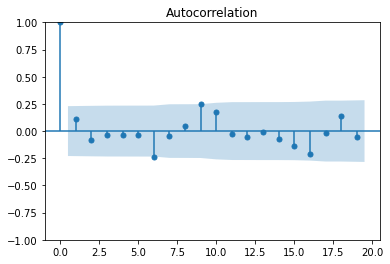

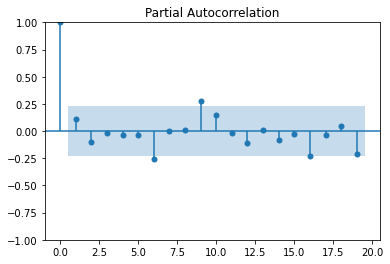

In [17]:
def lag_plots(data):
    """plots acf and pacf plots"""
    plot_acf(data)
    plot_pacf(data)
    
lag_plots(retailEcommercesales_ts[['Growth_rate']])

### ARIMA Model

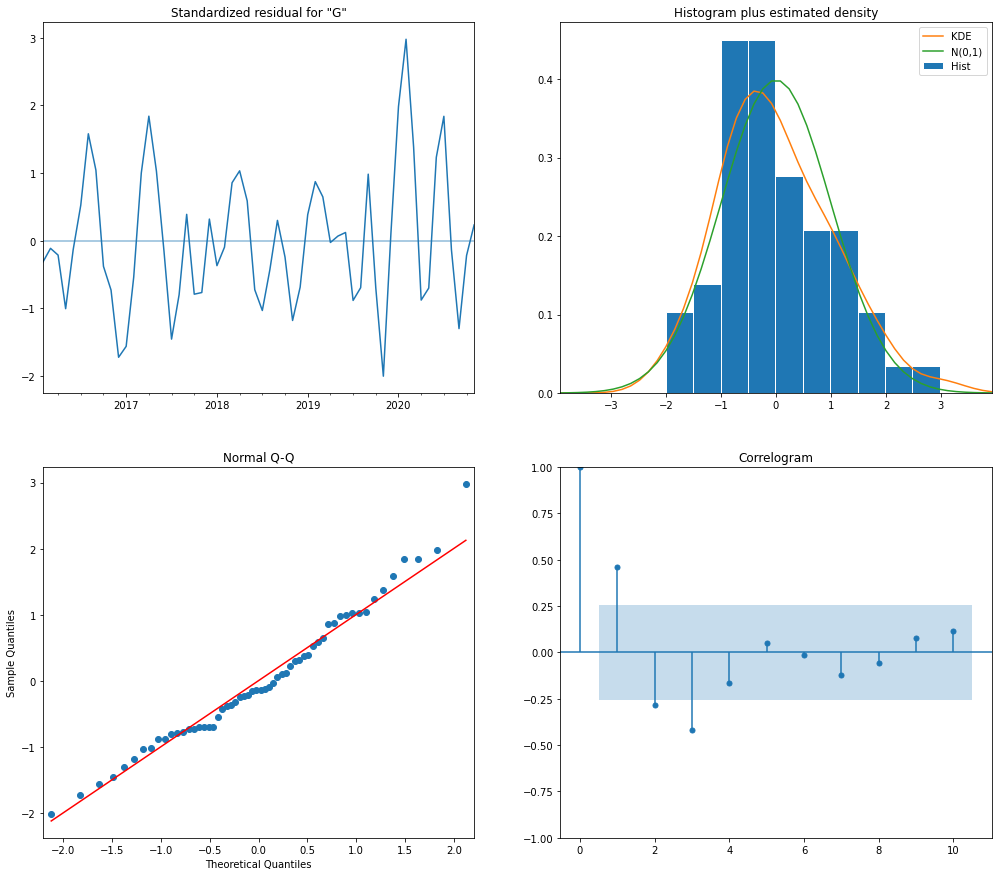

In [144]:
arimamodel_fit.plot_diagnostics(figsize=(17,15))
plt.show()

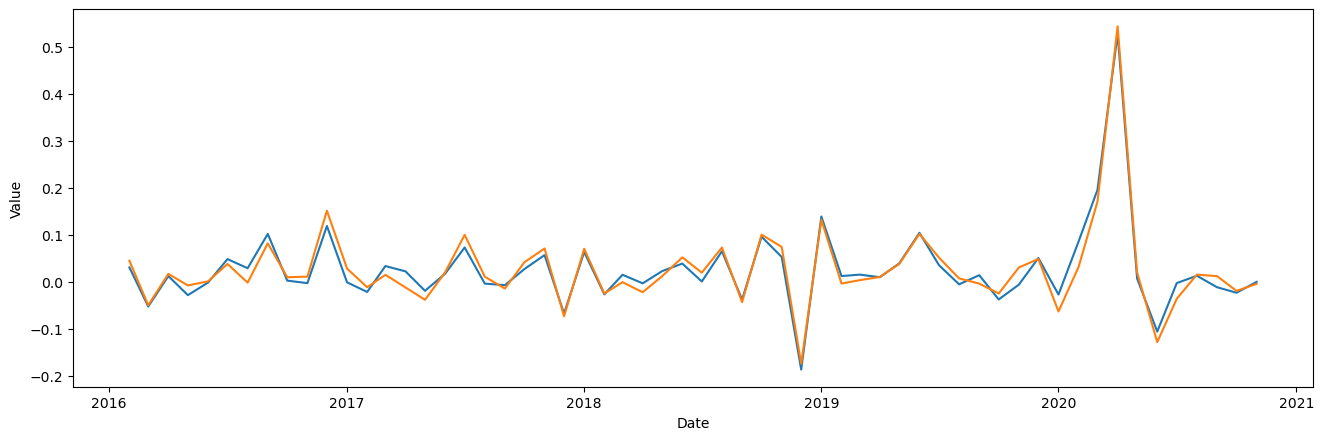

In [145]:
fitted_value = pd.DataFrame({'Original_sales' : train_df['Growth_rate'], 'Fitted_sales' : arimamodel_fit.predict()})
plot_df(fitted_value)

**Components of time series**

In [146]:
result=seasonal_decompose(retailEcommercesales_ts['Growth_rate'],  model='additive')

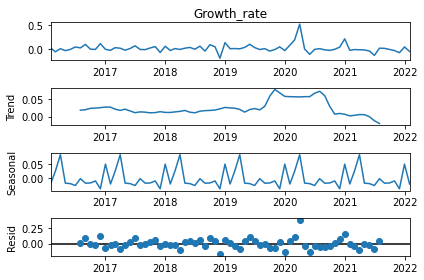

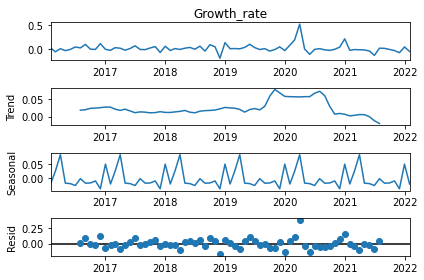

In [147]:
result.plot()

**ARIMA(1,0,1) with stationary data**

In [148]:
def fit_arima_model(train, dependent_var='Growth_rate', ar_order=1, ma_order=1):
    """ fits arma model to the training data set of GDP"""
    model = ARIMA(endog=train[dependent_var],
                  exog=train.loc[:, ~train.columns.isin([dependent_var])],
                  order=(ar_order, 0, ma_order))
    modelfit = model.fit(method='innovations_mle')
    return modelfit

arima_modelfit = fit_arima_model(train = train_df)
print(arima_modelfit.summary())

                               SARIMAX Results                                
Dep. Variable:            Growth_rate   No. Observations:                   58
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 147.913
Date:                Sat, 04 Jun 2022   AIC                           -209.825
Time:                        00:45:51   BIC                           -121.226
Sample:                    02-01-2016   HQIC                          -175.314
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0272      0.030      0.906      0.365      -0.032       0.086
Uber                        -0.0268      0.024     -1.139      0.255      -0.073       0.

### Rolling Prediction

In [149]:
def rolling_prediction_arima(train, test, dependent_var='Growth_rate'):
    """ Rolling prediction for test set"""
    train_samples = train.shape[0]
    test_samples = test.shape[0]
    pred_data = pd.DataFrame(columns=None)
    for i in range(train_samples+1, train_samples+test_samples+1):
        modelfit = fit_arima_model(train)

        # Get first row of test set and make prediction
        firstrow_test = np.transpose(pd.DataFrame((test.iloc[0, :])))
        predicted_val = modelfit.forecast(step=1,
                        exog=firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])], dynamic=True)
        predicted_val = pd.DataFrame(predicted_val)
        pred_data = pred_data.append(predicted_val)

        # update training set with one row
        train = pd.concat([train, firstrow_test])

        # Drop first row from test set now
        test = test.drop(f"{firstrow_test.index[0]}")

    return pred_data

In [150]:
# prediction using ARIMA
predict_df = rolling_prediction_arima(train_df, test_df)

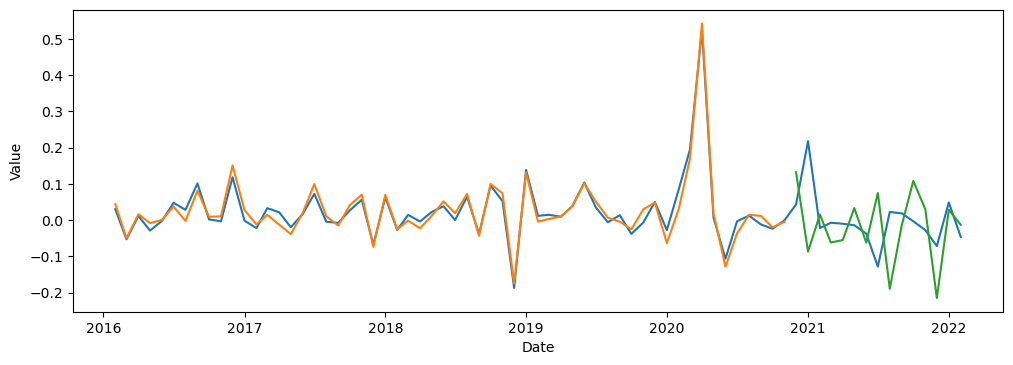

In [157]:
#growth rate prediction

fitted_values = pd.DataFrame({'Growth_rate': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value': arima_modelfit.predict(),
                              'Predicted Value': predict_df.squeeze()})
plot_df(fitted_values, width=12, height=4)

In [158]:
# to extract original ecommerce-sales

def fitted_and_predicted_sales(modelfit, predict_df, retailEcommercesales, train, test):
    """convert predicted growth rate to ecommerce sales value"""
    
    base_sales = retailEcommercesales['Ecommerce_sales'][0]
    fitted_values = modelfit.predict()
    fitted_sales = [0]*(len(fitted_values)+1)
    fitted_sales[0] = base_sales
    for i, value in enumerate(fitted_values):
        fitted_sales[i+1] = fitted_sales[i]*(1 + value)
    fitted_sales_df = pd.DataFrame(fitted_sales[1:])
    fitted_sales_df.index = train.index

    base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
    predicted_sales = [0]*(len(predict_df.squeeze()))
    actual_sales = base_sales_test
    for i, value in enumerate(predict_df.squeeze()):
        predicted_sales[i] = actual_sales*(1 + value)
        actual_sales = retailEcommercesales.loc[test.index[i]][0]
    predicted_sales_df = pd.DataFrame(predicted_sales)
    predicted_sales_df.index = predict_df.index
    predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])

    # prediction error calculation
    org = retailEcommercesales[retailEcommercesales.index >= predicted_sales_df.index[0]]
    error = 0
    for i in range(0, predicted_sales_df.shape[0]):
        error = error + (org['Ecommerce_sales'][i]-predicted_sales_df[0][i])**2
    pred_error = np.sqrt(error/predicted_sales_df.shape[0])
    print(f"Prediction error: {pred_error}")

    # Plot actual and fitted sales
    Actual_sales = retailEcommercesales['Ecommerce_sales'][1:]
    fittedandActual_sales = pd.DataFrame({'Actual sales': Actual_sales,
                                        'Fitted sales': fitted_sales_df.squeeze(),
                                        'Predicted sales': predicted_sales_df.squeeze()
                                       })
    plot_df(fittedandActual_sales, width=10, height=3)
    return pred_error


Prediction error: 445196.0747832321


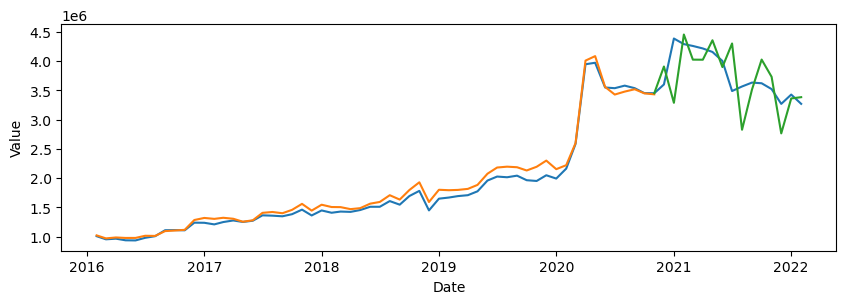

445196.0747832321

In [159]:
fitted_and_predicted_sales(arima_modelfit,predict_df, retailEcommercesales, train_df, test_df)

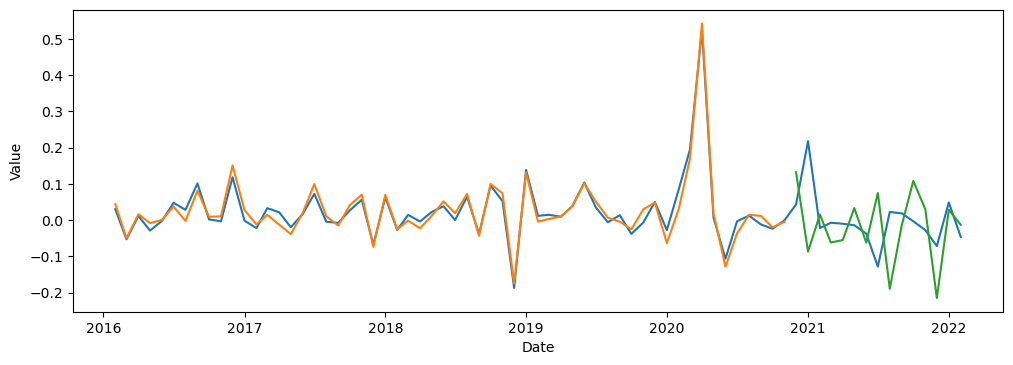

In [160]:
#growth rate prediction

fitted_values = pd.DataFrame({'Ecommerce_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value': arima_modelfit.predict(),
                              'Predicted Value': predict_df.squeeze()})
plot_df(fitted_values, width=12, height=4)

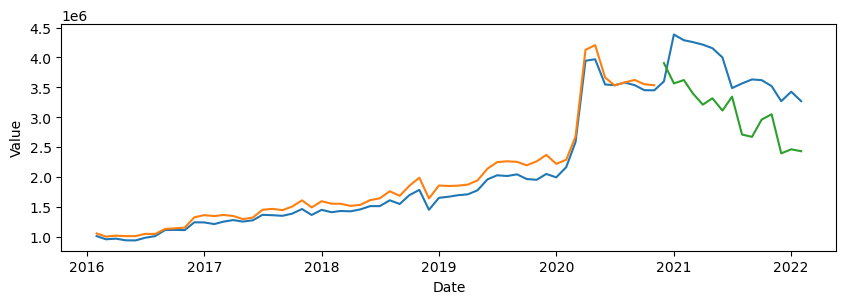

In [162]:
# Plot fitted and predicted Ecommerce

base_sales = retailEcommercesales_ts['Ecommerce_sales'][0]
fitted_values = arima_modelfit.predict()
fitted_sales = [0]*(len(fitted_values)+1)
fitted_sales[0] = base_sales
for i, value in enumerate(fitted_values):
    fitted_sales[i+1] = fitted_sales[i]*(1 + value)
fitted_sales_df = pd.DataFrame(fitted_sales[1:])
fitted_sales_df.index = train_df.index

base_sales = retailEcommercesales_ts[retailEcommercesales_ts.index == train_df.index[-1]]['Ecommerce_sales'][0]
predicted_sales = [0]*(len(predict_df.squeeze())+1)
predicted_sales[0] = base_sales
for i, value in enumerate(predict_df.squeeze()):
    predicted_sales[i+1] = predicted_sales[i]*(1 + value)
predicted_sales_df = pd.DataFrame(predicted_sales[1:])
predicted_sales_df.index = predict_df.index

# Plot actual and fitted GDP
Actual_sales = retailEcommercesales_ts['Ecommerce_sales']
fittedandActual_sales = pd.DataFrame({'Actual sales': Actual_sales,
                                    'Fitted sales': fitted_sales_df.squeeze(),
                                    'Predicted sales': predicted_sales_df.squeeze()
                                   })
plot_df(fittedandActual_sales, width=10, height=3)

**Note:** *Testing* 

**Temporary Lasso model**

In [ ]:
temp_list_key = []
for i in range(len(temp_array)):
    if temp_array[i] != 0 :
        temp_list_key.append(i)

temp_df = x_train(temp_list_key)

tempdf_lasso = pd.DataFrame(model.predict(x_train))
tempdf_lasso.index = y_train.index

[2, 5, 13, 17, 19, 22]


In [ ]:
# check the non-zero coefficients

model.coef_

array([ 0.        ,  0.        ,  0.00240302,  0.        , -0.        ,
       -0.00013845,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.04529451,  0.        ,
       -0.        ,  0.        , -0.0008379 ,  0.        , -0.00118373,
        0.        ,  0.        ,  0.04169599, -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ])

**Note:** *Testing*

**Uncorrelated predictors ARIMA model**

In [ ]:
cols = list()
data = pd.merge(retailEcommercesales, ecommerce_keyword_ts, left_index=True, right_index=True)

for i in range(0, data.iloc[:,2:].shape[1]):
    corr, _ = pearsonr(data['Ecommerce_sales'], data.iloc[:, i+2])
    if abs(corr) > 0.2:
        cols.append(data.columns[i+2])

In [ ]:
new_predictors = temp_data[cols]

In [ ]:
cor_temp_data = data[cols]

In [ ]:
cor_temp_data.head()

,DoorDash,SkipTheDishes,Walmart,Costco,ebay,kijiji,Canadian Tire,Best Buy,Shopify,Apple,Old Navy,eventbrite,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,
2016-01-01,0,0,17,24,67,62,33,34,24,25,0,7,69,60,55,50,16,12,18,58
2016-02-01,0,0,8,36,52,50,47,18,26,38,23,34,76,58,64,47,11,18,17,50
2016-03-01,0,0,11,25,59,60,24,44,25,25,22,63,72,56,59,52,10,15,13,38
2016-04-01,0,23,17,32,43,69,16,34,27,31,0,26,71,58,57,50,21,13,18,48
2016-05-01,2,0,11,40,54,39,29,54,28,100,67,28,69,59,67,53,54,18,90,40


In [ ]:
cor_predictors = make_predictors_df(cor_temp_data)
normalized_corr_keyword = normalize(cor_predictors)
detrend_corr_keyword = (detrend(normalized_corr_keyword))

In [ ]:
predict_corr_df = rolling_prediction(train_corr_df, test_corr_df)

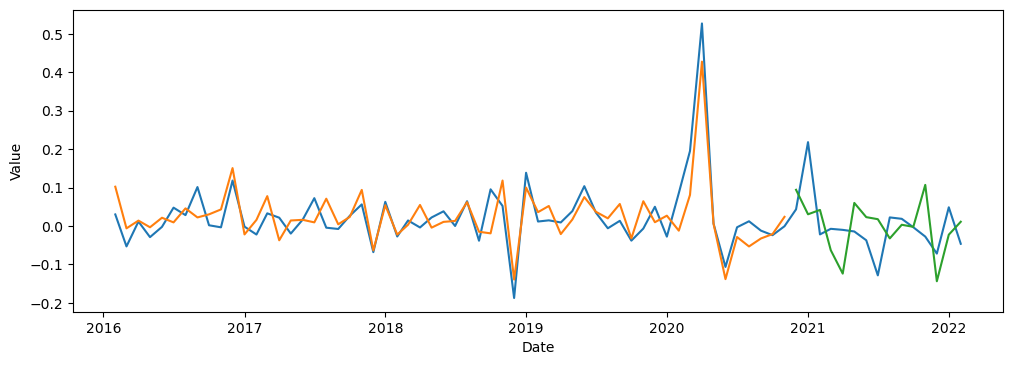

In [141]:
# growth rate prediction

fitted_values = pd.DataFrame({'Growth_rate': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value': corr_modelfit.predict(),
                              'Predicted Value': predict_corr_df.squeeze()})
plot_df(fitted_values, width=12, height=4)

Prediction error: 49145.2896086548


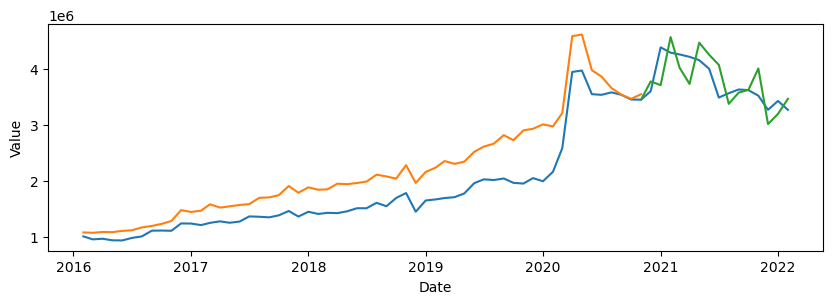

49145.2896086548

In [146]:
# ecommerce sales prediction

fitted_and_predicted_sales(corr_modelfit, predict_corr_df, retailEcommercesales, train_corr_df, test_corr_df)

**Note:** *Testing*

**Correlation with GDP keywords data**

*File - correlated_ecommerce.ipynb*

In [247]:
temp_data = pd.read_csv("gdp_category_ts.csv", index_col = 0)
temp_data.head(2)

,569,23,47,815,170,249,71,276,634,250,...,53,342,1159,1214,670,12,566,672,673,49
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,74,90,91,94,89,86,76,57,60,90,...,100,90,95,77,68,100,88,74,91,88
2004-02-01,70,85,89,93,88,87,72,58,52,98,...,96,100,95,91,77,99,96,79,82,100


In [255]:
temp_data.rename(index={'date': 'Date'}, inplace=True)

In [258]:
temp_data.index = pd.to_datetime(temp_data.index) 

### DFM model

In [163]:
def apply_dfm(predictor, num_factors=20, order_factors=1):
    """DSM fit"""
    model = sm.tsa.DynamicFactor(endog=predictor, k_factors=num_factors, factor_order=order_factors)
    res = model.fit()
    final = model.fit(res.params)
    factors = np.transpose(pd.DataFrame(final.factors.filtered))
    factors.index = predictor.index
    return factors

dfm_df = apply_dfm(detrend_ecommerce_keyword)

In [164]:
dfm_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2004-02-01,-0.010634,0.004942,0.056816,-0.046442,-0.075361,0.089082,0.007283,-0.126831,0.064236,-0.299478,-0.112300,-0.030269,-0.049100,0.031644,0.072971,-0.073296,-0.290568,0.114685,-0.080020,-0.161779
2004-03-01,-0.018024,-0.071668,-0.040090,0.256949,0.133195,-0.078806,0.237359,-0.044918,0.015494,0.276559,0.083838,0.084333,0.206234,-0.125262,-0.016373,0.024299,0.013324,0.002681,0.005089,0.099757
2004-04-01,0.041573,-0.023285,-0.055871,-0.155987,-0.115148,0.034524,-0.184349,0.039858,-0.030918,-0.020438,-0.044968,-0.125850,-0.091019,-0.005577,-0.024417,0.056058,0.020243,-0.055334,0.065977,0.055450
2004-05-01,0.003533,0.109643,0.112232,-0.067461,0.028003,0.075018,-0.046467,0.093390,-0.038580,-0.190688,-0.012127,0.112537,-0.151078,0.181247,0.022774,-0.050040,0.101095,0.119300,-0.129689,-0.175465
2004-06-01,0.019946,-0.035926,-0.106842,0.110006,0.028492,-0.136350,0.108719,-0.148933,0.002545,0.093812,0.006777,-0.130849,0.111020,-0.193841,-0.028804,-0.023804,-0.052658,-0.066228,0.042138,0.221626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,0.073973,0.056237,0.084236,0.151351,0.073099,-0.144073,0.018727,0.244396,0.022596,-0.085048,0.173894,-0.178313,0.056605,0.155530,-0.047877,-0.020452,-0.041906,0.041498,-0.035724,-0.095937
2022-02-01,-0.058064,-0.027630,-0.185230,-0.006985,-0.078015,0.118476,-0.044313,-0.101303,-0.071948,-0.056800,-0.120880,0.120148,-0.005238,-0.007786,0.018113,-0.052499,-0.046458,-0.144404,-0.083793,0.097224
2022-03-01,-0.034498,-0.267480,0.254562,-0.054001,0.077565,0.077667,0.191382,0.002155,-0.039820,-0.117426,0.048676,-0.064629,0.066898,-0.127638,-0.162617,0.036000,0.038838,0.009752,0.143505,-0.082285


**DFM factor selection**

In [165]:
# dataset split

train_dfm_df, test_dfm_df, extra_dfm_df = ts_train_test_split(retailEcommercesales_ts['Growth_rate'], dfm_df.iloc[:,0:15], test_size=0.2)
dfm_modelfit = fit_arima_model(train_dfm_df, dependent_var='Growth_rate', ar_order=1, ma_order=1)

In [166]:
#prediction using DFM model fit

predict_dfm_df = rolling_prediction(train_dfm_df, test_dfm_df)

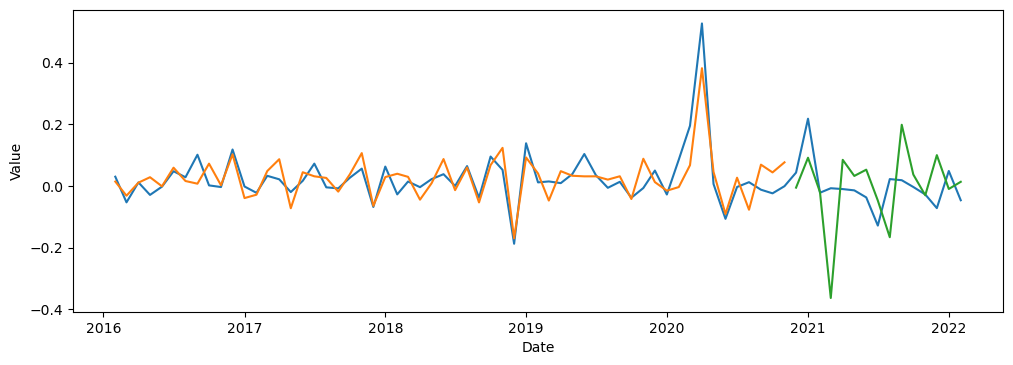

In [167]:
#growth rate prediciton

fitted_values = pd.DataFrame({'Growth_rate': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value': dfm_modelfit.predict(),
                              'Predicted Value': predict_dfm_df.squeeze()})
plot_df(fitted_values, width=12, height=4)

Prediction error: 519539.1127435608


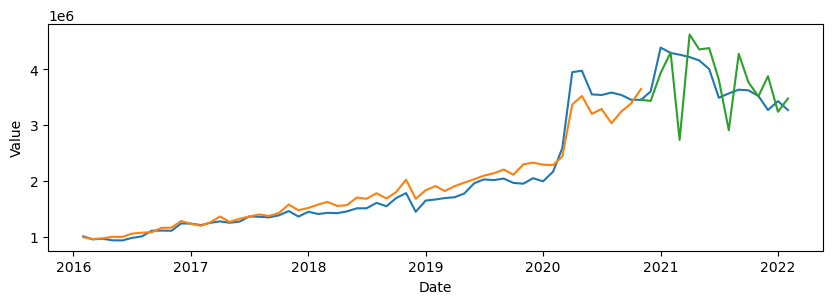

519539.1127435608

In [168]:
#ecommerces sales prediciton

fitted_and_predicted_sales(dfm_modelfit,predict_dfm_df, retailEcommercesales, train_dfm_df, test_dfm_df)

### XGBoost Model

In [169]:
def get_lag1_data(retailEcommercesales_ts, ecommerce_keyword_ts, response_var='Growth_rate'):
    """ passed response dataframe and predictors' dataframe"""
    lasso_key = detrend(normalize(ecommerce_keyword_ts))
    
    # response
    lasso_response_var = retailEcommercesales_ts[[response_var]].iloc[1:,:]

    # extract lag1 data to add to predictors
    lag1 = retailEcommercesales_ts[[response_var]].iloc[0:retailEcommercesales_ts.shape[0]-1,:]
    lag1.index = lasso_response_var.index
    lag1 = lag1.rename(columns={response_var: 'lag1'})
    lasso_predictors = make_predictors_df(lag1, lasso_key)
    
    # extra test data
    predictors_with_extra = make_predictors_df(lasso_key)
    extra_test_data = predictors_with_extra.loc[predictors_with_extra.index > lasso_predictors.index[len(lasso_predictors.index)-1], :]
    extra_test_data['lag1'] = lasso_response_var.iloc[-1][0]
    lasso_predictors = pd.concat([lasso_predictors, extra_test_data])
    return lasso_predictors, lasso_response_var

In [172]:
def xgboost_modelfit(train_xgboost, dependent_var='Growth_rate'):
    """ fits xgboost model to the passed data"""
    X_xgboost, Y_xgboost = train_xgboost.loc[:, ~train_xgboost.columns.isin([dependent_var])], train_xgboost[[dependent_var]]
    xgboostmodel = XGBRegressor(objective ='reg:squarederror', n_estimators=500,learning_rate=0.1,alpha=0.06)
    xgboostmodel.fit(X_xgboost, Y_xgboost)
    return xgboostmodel

In [174]:
# predictor lag1
xgboost_predictors, xgboost_response = get_lag1_data(retailEcommercesales_ts, detrend_ecommerce_keyword)

#model fitted on data split

train_xgboost, test_xgboost, extra_test = ts_train_test_split(xgboost_response, xgboost_predictors, test_size=0.2)
xgboostmodel = xgboost_modelfit(train_xgboost)
train_xgboost.shape

(57, 41)

In [175]:
#  split the data

trainX, trainy = train_xgboost.iloc[:, 1:], train_xgboost['Growth_rate']
testX, testy = test_xgboost.iloc[:, 1:], test_xgboost.iloc[:, -0]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

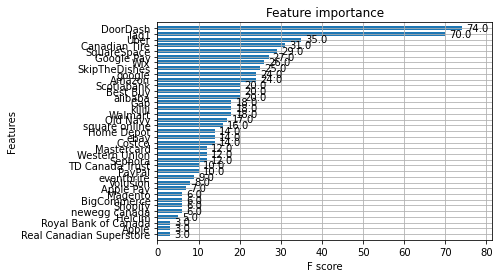

In [176]:
# plot of important or most weighted predictors

plot_importance(xgboostmodel, height=0.7)

In [177]:
# predictions

fitted_growthRate_xgboost = xgboostmodel.predict(trainX)
fitted_growthRate_xgboost.squeeze()
fitted_growthRate_xgboost = pd.DataFrame(fitted_growthRate_xgboost, columns={'Fitted Ecommerce_GrowthRate'})
fitted_growthRate_xgboost.index = train_xgboost.index

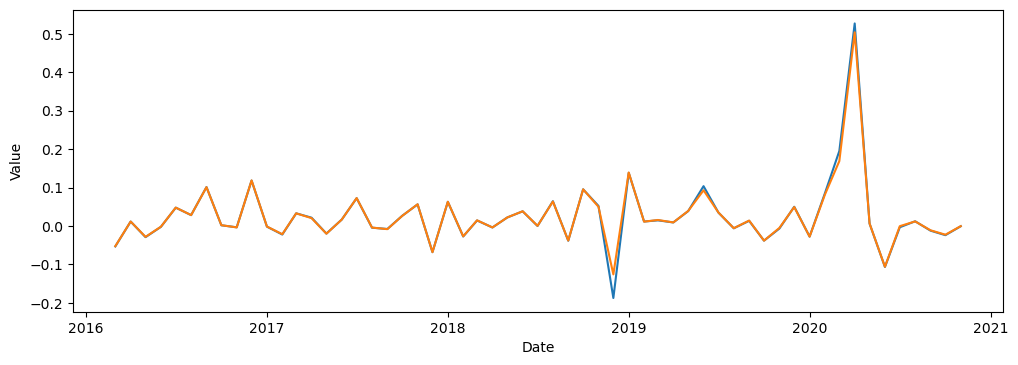

In [178]:
# growth rate prediction

fitted_values_xgboost = pd.DataFrame({'GrowthRate': train_xgboost['Growth_rate'],
                              'Fitted Value': fitted_growthRate_xgboost.squeeze()})
plot_df(fitted_values_xgboost, width=12, height=4)

In [179]:
def rolling_prediction_xgboost(train, test,extra_test, dependent_var='Growth_rate'):
    """ Rolling prediction for xgboost"""
    train_copy = train.copy()
    test_copy = test.copy()
    train_samples = train.shape[0]
    test_samples = test.shape[0]
    pred_data = pd.DataFrame(columns=None)

    # rolling prediction for testing set
    if not test.empty:
        for i in range(train_samples+1, train_samples+test_samples+1):
            modelfit = xgboost_modelfit(train_xgboost)

            # Get first row of test set and make prediction
            firstrow_test = np.transpose(pd.DataFrame((test.iloc[0, :])))
            predicted_val = modelfit.predict(firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])])
            predicted_val = pd.DataFrame(predicted_val)
            pred_data = pred_data.append(predicted_val)

            # update training set with one row
            train = pd.concat([train, firstrow_test])

            # Drop first row from test set now
            test = test.drop(f"{firstrow_test.index[0]}")

        pred_data.index = test_copy.index

    # rolling prediction for extra test set
    if not extra_test.empty:
        for i in range(0, extra_test.shape[0]):
            modelfit = xgboost_modelfit(train_xgboost)

            # Get first row of extra test set and make prediction
            firstrow_test = np.transpose(pd.DataFrame((extra_test.iloc[0, :])))
            firstrow_test['lag1'] = firstrow_test.tail(1)['lag1'][0]
            predicted_val = modelfit.predict(firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])])
            firstrow_test['Growth_rate'] = predicted_val[0]
            predicted_val = pd.DataFrame(predicted_val)
            pred_data = pred_data.append(predicted_val)
            pred_data.rename(index={0:extra_test.index[0]}, inplace=True)

            # update training set with one row
            train = pd.concat([train, firstrow_test])

            # Drop first row from test set now
            extra_test = extra_test.drop(f"{firstrow_test.index[0]}")

    return pred_data

In [180]:
xgboost_pred_salesgrowth = rolling_prediction_xgboost(train_xgboost, test_xgboost, extra_test, dependent_var='Growth_rate')

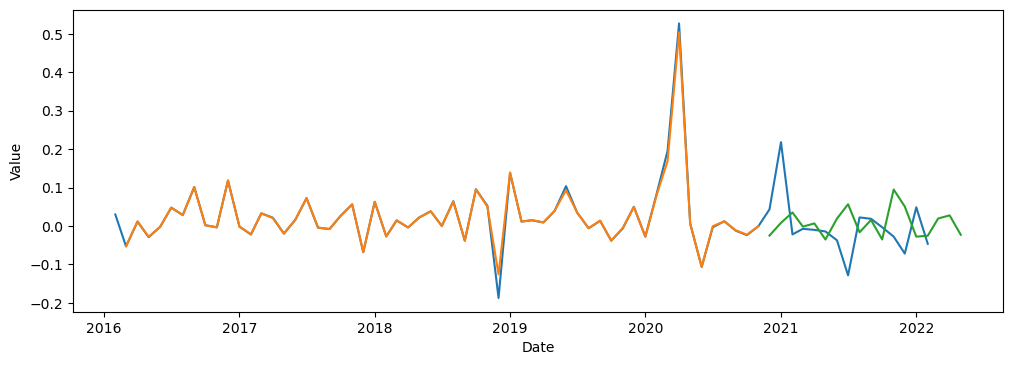

In [181]:
# fitted and predicted plot of growth rate

fitted_values_xgboost = pd.DataFrame({'Ecommerce_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                'Fitted Value': fitted_growthRate_xgboost.squeeze(),
                                'Predicted Value': xgboost_pred_salesgrowth.squeeze()})
plot_df(fitted_values_xgboost, width=12, height=4)

In [58]:
# def fitted_and_predicted_sales_xgboost(modelfit, pred_EcommerceGrowth, retailEcommercesales, train, test):
#     base_sales = retailEcommercesales['Ecommerce_sales'][1]

#     # calculate fitted gdp
#     X_xgboost = train.loc[:, ~train.columns.isin(['Growth_rate'])]
#     fitted_values = modelfit.predict(X_xgboost)  # fitted growth rate
#     fitted_values = pd.DataFrame(fitted_values, columns={'Fitted EcommerceSales_GrowthRate'})
#     fitted_values.index = train.index

#     fitted_sales = [0]*(len(fitted_values)+1)
#     fitted_sales[0] = base_sales
#     for i, value in enumerate(fitted_values['Fitted EcommerceSales_GrowthRate']):
#         fitted_sales[i+1] = fitted_sales[i]*(1 + value)
#     fitted_sales_df = pd.DataFrame(fitted_sales[1:])
#     fitted_sales_df.index = train.index

#     base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
#     predicted_sales = [0]*(len(pred_EcommerceGrowth.squeeze()))
#     actual_sales = base_sales_test
#     for i, value in enumerate(pred_EcommerceGrowth.squeeze()):
#         predicted_sales[i] = actual_sales*(1 + value)
#         actual_sales = retailEcommercesales.loc[test.index[i]][0]
#     predicted_sales_df = pd.DataFrame(predicted_sales)
#     predicted_sales_df.index = pred_EcommerceGrowth.index
#     predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])

#     # prediction error calculation
#     org = retailEcommercesales[retailEcommercesales.index >= predicted_sales_df.index[0]]
#     error = 0
#     for i in range(0, predicted_sales_df.shape[0]):
#         error = error + (org['Ecommerce_sales'][i]-predicted_sales_df[0][i])**2
#     pred_error = np.sqrt(error/predicted_sales_df.shape[0])
#     print(f"Prediction error: {pred_error}")

#     # Plot actual and fitted GDP
#     Actual_sales = retailEcommercesales['Ecommerce_sales'][1:]
#     fittedandActual_sales = pd.DataFrame({'Actual EcommerceSales': Actual_sales,
#                                         'Fitted EcommerceSales': fitted_sales_df.squeeze(),
#                                         'Predicted EcommerceSales': predicted_sales_df.squeeze()
#                                        })
#     plot_df(fittedandActual_sales, width=10, height=3)
#     return pred_error, fittedandActual_sales



In [182]:
def fitted_and_predicted_sales_xgboost(modelfit, pred_EcommerceGrowth, retailEcommercesales, train, test, extra_test):
    base_sales = retailEcommercesales['Ecommerce_sales'][1]
    
    # calculate fitted retail sales
    X_xgboost = train.loc[:, ~train.columns.isin(['Growth_rate'])]
    fitted_values = modelfit.predict(X_xgboost)  # fitted growth rate
    fitted_values = pd.DataFrame(fitted_values, columns={'Fitted GrowthRate'})
    fitted_values.index = train.index
    
    fitted_sales = [0]*(len(fitted_values)+1)
    fitted_sales[0] = base_sales
    for i, value in enumerate(fitted_values['Fitted GrowthRate']):
        fitted_sales[i+1] = fitted_sales[i]*(1 + value)
    fitted_sales_df = pd.DataFrame(fitted_sales[1:])
    fitted_sales_df.index = train.index

    #Test
    base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
    predicted_sales = [0]*pred_EcommerceGrowth.shape[0]
    actual_sales = base_sales_test
    if not test.empty:
        for i in range(0, test.shape[0]):
            value = pred_EcommerceGrowth[0][i]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = retailEcommercesales.loc[test.index[i]][0]
        predicted_sales_df = pd.DataFrame(predicted_sales)
        predicted_sales_df.index = pred_EcommerceGrowth.index
        predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])

        # prediction error calculation
        org = retailEcommercesales[retailEcommercesales.index >= pred_EcommerceGrowth.index[0]]
        error = 0
        for i in range(0, test.shape[0]):
            error = error + (org['Ecommerce_sales'][i]-predicted_sales_df[0][i])**2
        pred_error = np.sqrt(error/predicted_sales_df.shape[0])
        print(f"Prediction error: {pred_error}")

    # predicted sales trade value for extra test set when test set is not empty
    if not extra_test.empty and not test.empty:
        base_sales_test = retailEcommercesales[retailEcommercesales.index == test.index[-1]]['Ecommerce_sales'][0]
        actual_sales = base_sales_test
        for i in range(0, extra_test.shape[0]):
            value = pred_EcommerceGrowth.iloc[test.shape[0]+i][0]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = predicted_sales[i]
            predicted_sales_df.iloc[test.shape[0]+i+1][0] = predicted_sales[i]

    # predicted sales trade value for extra test set when test set is empty
    if not extra_test.empty and test.empty:
        base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
        actual_sales = base_sales_test
        for i in range(0, extra_test.shape[0]):
            value = pred_EcommerceGrowth.iloc[i][0]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = predicted_sales[i]
        predicted_sales_df = pd.DataFrame(predicted_sales)
        predicted_sales_df.index = pred_EcommerceGrowth.index
        predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])
        pred_error = None


    # Plot actual and fitted retail trade
    Actual_sales = retailEcommercesales['Ecommerce_sales'][1:]
    fittedandActual_sales = pd.DataFrame({'Actual Retail': Actual_sales,
                                        'Fitted Retail': fitted_sales_df.squeeze(),
                                        'Predicted Retail': predicted_sales_df.squeeze()
                                       })
    fig = plot_df(fittedandActual_sales, width=10, height=3)
    return pred_error, fig, fittedandActual_sales

Prediction error: 410953.3448875869


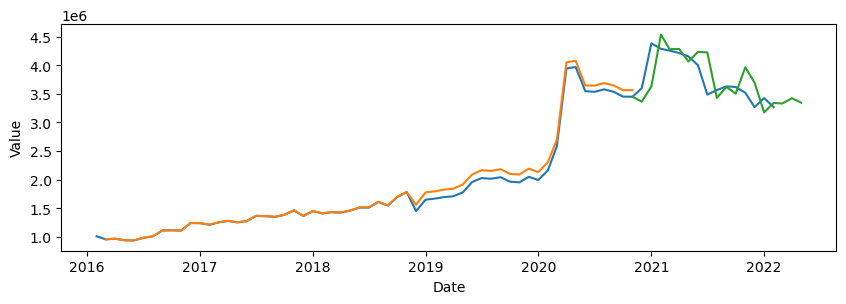

In [183]:
# fitted and predicted plot

_, plot_sales, actual_sales = fitted_and_predicted_sales_xgboost(xgboostmodel, xgboost_pred_salesgrowth, retailEcommercesales, train_xgboost, test_xgboost, extra_test)
plot_sales

**Cross-validation of Xgboost**

In [ ]:
def xgboost_modelfit(train_xgboost, dependent_var='Growth_rate',learningrate=0.01,L1_regulalization=0.1,n_estimators=500):
    """ fits xgboost model to the passed data"""
    X_xgboost, Y_xgboost = train_xgboost.loc[:, ~train_xgboost.columns.isin([dependent_var])], train_xgboost[[dependent_var]]
    xgboostmodel = XGBRegressor(objective ='reg:squarederror',learning_rate=learningrate,alpha=L1_regulalization, n_estimators=n_estimators)
    xgboostmodel.fit(X_xgboost, Y_xgboost)
    return xgboostmodel

In [ ]:
def rolling_prediction_xgboost(train_xgboost, test_xgboost, dependent_var='Growth_rate',learningrate = 0.01,L1_regulalization=0.1,n_trees=500):
    """ Rolling prediction for xgboost"""
    train_samples = train_xgboost.shape[0]
    test_samples = test_xgboost.shape[0]
    pred_data = pd.DataFrame(columns=None)
    test_data = test_xgboost.copy()
    for i in range(train_samples+1, train_samples+test_samples+1):
        modelfit = xgboost_modelfit(train_xgboost,learningrate=learningrate,L1_regulalization=L1_regulalization,n_estimators=n_trees)

        # Get first row of test set and make prediction
        firstrow_test = np.transpose(pd.DataFrame((test_xgboost.iloc[0, :])))
        predicted_val = modelfit.predict(firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])])
        predicted_val = pd.DataFrame(predicted_val)
        pred_data = pred_data.append(predicted_val)

        # update training set with one row
        train_xgboost = pd.concat([train_xgboost, firstrow_test])

        # Drop first row from test set now
        test_xgboost = test_xgboost.drop(f"{firstrow_test.index[0]}")

    pred_data.index = test_data.index
    return pred_data

In [95]:
def cv_model_xgboost(kfolds=5,train_set=train_xgboost,dependent_var='Growth_rate',learningrate=0.01,L1_regulalization=0.1,n_trees=500):
    entry_count = int(train_set.shape[0]/kfolds)
    train = train_set.iloc[:entry_count,:]
    error = 0

    for i in range(entry_count,len(train_set),entry_count):
        test = train_set.iloc[i:i+entry_count,:]
        #rfmodel_temp = modeltype(train, dependent_var)
        pred_growthrate_rf_temp = rolling_prediction_xgboost(train, test,dependent_var,learningrate,L1_regulalization,n_trees)
        pred_growthrate_rf_temp = pred_growthrate_rf_temp.rename(columns = {0:dependent_var})
        #train_df = pd.merge(test_new,pred_growthrate_rf_temp,left_index=True, right_index = True)
        train = train.append(test)
        error = error + np.sqrt(np.mean(pow(pred_growthrate_rf_temp[dependent_var] - test[dependent_var],2)))
    return error/(kfolds-1)

In [100]:
# cross validation
kfolds = 5
min_alpha = 0
min_learningrate=0
max_alpha = 0.2
max_learningrate=0.2
step_size_alpha = 0.01
step_size_learningrate = 0.01
xgboost_cv_df = pd.DataFrame(columns=["Alpha", "Cross validation error"])
for i, alpha_val in enumerate(np.arange(min_alpha, max_alpha+step_size_alpha, step_size_alpha)):
    for j,learningrate_val in enumerate(np.arange(min_learningrate, max_learningrate+step_size_learningrate, step_size_learningrate)):
        error = cv_model_xgboost(kfolds, train_xgboost, 'Growth_rate', learningrate=learningrate_val,L1_regulalization=alpha_val)
        xgboost_cv_df.loc[i, "Alpha"] = alpha_val
        xgboost_cv_df.loc[i, "LearningRate"] = learningrate_val
        xgboost_cv_df.loc[i, "Cross validation error"] = error


KeyboardInterrupt



In [99]:
print(xgboost_cv_df[xgboost_cv_df['Cross validation error'] == xgboost_cv_df['Cross validation error'].min()])

  Alpha Cross validation error  LearningRate
6  0.06               0.172556           0.1


### Lasso model w/t lags

In [184]:
def lasso_modelfit(train_lasso, dependent_var='Growth_rate', alpha=0.001):
    """ fits lasso model to the passed data"""
    X_lasso, y_lasso = train_lasso.loc[:, ~train_lasso.columns.isin([dependent_var])], train_lasso[[dependent_var]]
    lassomodel = Lasso(alpha=alpha)
    lassomodel.fit(X_lasso, y_lasso)
    return lassomodel

In [186]:
lasso_predictors, lasso_response = get_lag1_data(retailEcommercesales_ts, ecommerce_keyword_ts, response_var='Growth_rate')

In [187]:
print(lasso_predictors.shape)
print(lasso_response.shape)

(75, 40)
(72, 1)


In [194]:
train_lasso, test_lasso, extra_lasso = ts_train_test_split(lasso_response, lasso_predictors, test_size=0.2)
train_lasso.shape

(57, 41)

In [189]:
lassomodel = lasso_modelfit(train_lasso, alpha=0.001)

# fitted growth rate
X_lasso, y_lasso = train_lasso.loc[:, ~train_lasso.columns.isin(['Growth_rate'])], train_lasso[['Growth_rate']]
fitted_growthRate_lasso = lassomodel.predict(X_lasso)
fitted_growthRate_lasso = pd.DataFrame(fitted_growthRate_lasso, columns={'Fitted Ecommerce_GrowthRate'})
fitted_growthRate_lasso.index = train_lasso.index

In [190]:
print(lassomodel.n_features_in_)

40


In [191]:
def rolling_prediction_lasso(train, test, dependent_var='Growth_rate', alpha=0.001):
    """ Rolling prediction for lasso"""
    train_samples = train.shape[0]
    test_samples = test.shape[0]
    pred_data = pd.DataFrame(columns=None)
    test_data = test.copy()
    for i in range(train_samples+1, train_samples+test_samples+1):
        modelfit = lasso_modelfit(train, alpha=alpha)

        # Get first row of test set and make prediction
        firstrow_test = np.transpose(pd.DataFrame((test.iloc[0, :])))
        predicted_val = modelfit.predict(firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])])
        predicted_val = pd.DataFrame(predicted_val)
        pred_data = pred_data.append(predicted_val)

        # update training set with one row
        train = pd.concat([train, firstrow_test])

        # Drop first row from test set now
        test = test.drop(f"{firstrow_test.index[0]}")

    pred_data.index = test_data.index
    return pred_data

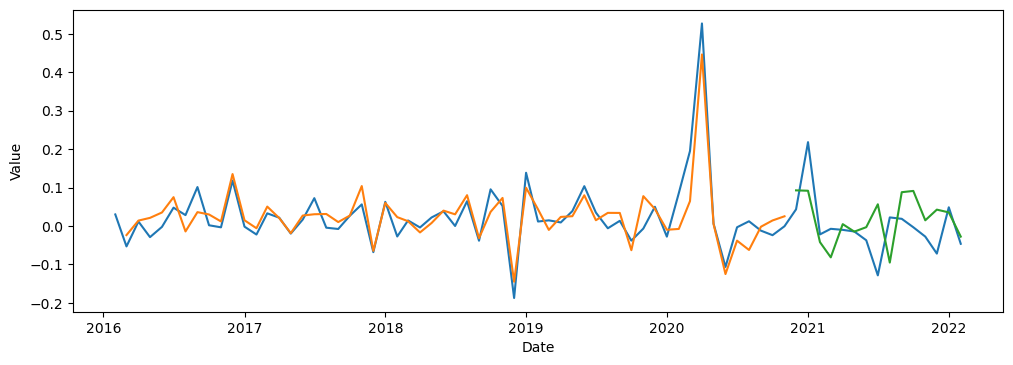

In [192]:
#growth rate prediction

lasso_pred_ecommerceGrowthRate = rolling_prediction_lasso(train_lasso, test_lasso, dependent_var='Growth_rate')
fitted_values_lasso = pd.DataFrame({'EcommerceSales_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                'Fitted Value': fitted_growthRate_lasso.squeeze(),
                                'Predicted Value': lasso_pred_ecommerceGrowthRate.squeeze()})
plot_df(fitted_values_lasso, width=12, height=4)

Prediction error: 301480.7390046056


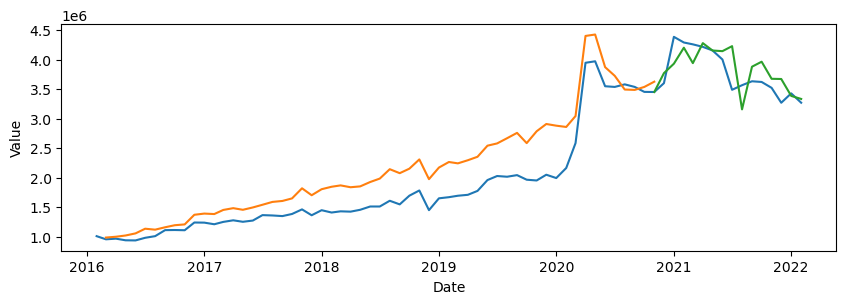

301480.7390046056

In [218]:
# fitted and predicted plot

plot_sales, actual_sales = fitted_and_predicted_sales_xgboost(lassomodel, lasso_pred_ecommerceGrowthRate, retailEcommercesales, train_lasso, test_lasso)
plot_sales

In [67]:
def cv_model_lasso(kfolds=5,train_set=train_lasso,dependent_var='Growth_rate',alpha = 0.001):
    entry_count = int(train_set.shape[0]/kfolds)
    train = train_set.iloc[:entry_count,:]
    error = 0
    
    for i in range(entry_count,len(train_set),entry_count):
        test = train_set.iloc[i:i+entry_count,:]
        pred_growthrate_rf_temp = rolling_prediction_lasso(train, test,dependent_var,alpha)
        pred_growthrate_rf_temp = pred_growthrate_rf_temp.rename(columns = {0:dependent_var})
        #train_df = pd.merge(test_new,pred_growthrate_rf_temp,left_index=True, right_index = True)
        train = train.append(test)
        error = error + np.sqrt(np.mean(pow(pred_growthrate_rf_temp[dependent_var] - test[dependent_var],2)))
    return error/(kfolds-1)

In [68]:
cv_model_lasso(kfolds=5,train_set=train_lasso,dependent_var='Growth_rate',alpha = 0.001)

0.11737554508644502

In [69]:
# cross validation
kfolds = 5
min_alpha = 0.001
max_alpha = 0.1
step_size_alpha = 0.0001
lasso_cv_df = pd.DataFrame(columns=["Alpha", "Cross validation error"])
for i, alpha_val in enumerate(np.arange(min_alpha, max_alpha+step_size_alpha, step_size_alpha)):
    error = cv_model_lasso(kfolds, train_lasso, 'Growth_rate', alpha_val)
    lasso_cv_df.loc[i, "Alpha"] = alpha_val
    lasso_cv_df.loc[i, "Cross validation error"] = error

In [70]:
print(lasso_cv_df[lasso_cv_df['Cross validation error'] == lasso_cv_df['Cross validation error'].min()])

      Alpha Cross validation error
616  0.0626                0.09272
617  0.0627                0.09272
618  0.0628                0.09272
619  0.0629                0.09272
620   0.063                0.09272
..      ...                    ...
986  0.0996                0.09272
987  0.0997                0.09272
988  0.0998                0.09272
989  0.0999                0.09272
990     0.1                0.09272

[375 rows x 2 columns]


### Random Forest

In [196]:
def randomForest_modelfit(train_rf, dependent_var='Growth_rate',n_trees=100):
    """ fits Random Forest model to the passed data"""
    x_train, y_train = train_rf.loc[:, ~train_rf.columns.isin([dependent_var])], train_rf[[dependent_var]]
    RFmodel = RandomForestRegressor(n_estimators=n_trees)
    RFmodel.fit(x_train, y_train)
    return RFmodel

In [197]:
def rolling_prediction_RF(train, test, dependent_var='Growth_rate',n_trees=100):
    """ Rolling prediction for test set"""
    train_samples = train.shape[0]
    test_samples = test.shape[0]
    pred_data = pd.DataFrame(columns=None)
    test_data = test.copy()
    for i in range(train_samples+1, train_samples+test_samples+1):
        modelfit = randomForest_modelfit(train, dependent_var,n_trees=100)

        # Get first row of test set and make prediction
        firstrow_test = np.transpose(pd.DataFrame((test.iloc[0, :])))
        predicted_val = modelfit.predict(firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])])
        predicted_val = pd.DataFrame(predicted_val)
        pred_data = pred_data.append(predicted_val)

        # update training set with one row
        train = pd.concat([train, firstrow_test])

        # Drop first row from test set now
        test = test.drop(f"{firstrow_test.index[0]}")

    pred_data.index = test_data.index
    return pred_data

In [198]:
# RF Feature Importance Plot
def plot_feature_importance(importance, names, model_type, most_important_predictors=20):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df=fi_df.sort_values(by=['feature_importance'], ascending=False)
    fi_df=fi_df[0:most_important_predictors]

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Seaborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

**Model fitting Random Forest**

In [199]:
# get data for random forest
rf_predictors, rf_response = get_lag1_data(retailEcommercesales_ts, detrend_ecommerce_keyword, response_var='Growth_rate')

print(rf_predictors.shape)
print(rf_response.shape)

(75, 40)
(72, 1)


In [200]:
# train test split
train_rf, test_rf, _ = ts_train_test_split(rf_response, rf_predictors, test_size=0.2)
train_rf.shape

(57, 41)

In [214]:
# fit model
rfmodel = randomForest_modelfit(train_rf, dependent_var='Growth_rate',n_trees=600)

# fitted growth rate
X_rf, y_rf = train_rf.loc[:, ~train_rf.columns.isin(['Growth_rate'])], train_rf[['Growth_rate']]
fitted_growthRate_rf = rfmodel.predict(X_rf)
fitted_growthRate_rf = pd.DataFrame(fitted_growthRate_rf, columns={'Fitted EcommerceSales_GrowthRate'})
fitted_growthRate_rf.index = train_rf.index

In [215]:
# Rolling prediction of growth rate

pred_growthrate_rf = rolling_prediction_RF(train_rf, test_rf, dependent_var='Growth_rate',n_trees=600)

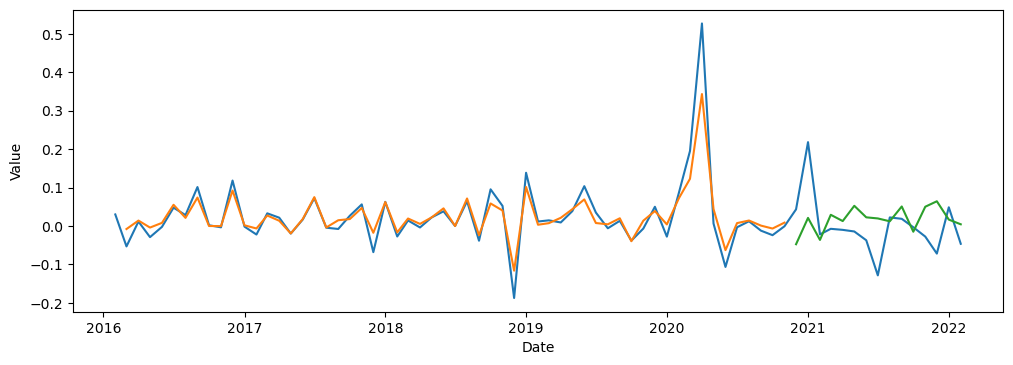

In [216]:
#fitted Ecommerce Sales

fitted_values_rf = pd.DataFrame({'EcommerceSales_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                'Fitted Value': fitted_growthRate_rf.squeeze(),
                                'Predicted Value': pred_growthrate_rf.squeeze()})
plot_df(fitted_values_rf, width=12, height=4)

In [205]:
def fitted_and_predicted_sales_xgboost(modelfit, pred_EcommerceGrowth, retailEcommercesales, train, test):
    base_sales = retailEcommercesales['Ecommerce_sales'][1]

    # calculate fitted gdp
    X_xgboost = train.loc[:, ~train.columns.isin(['Growth_rate'])]
    fitted_values = modelfit.predict(X_xgboost)  # fitted growth rate
    fitted_values = pd.DataFrame(fitted_values, columns={'Fitted EcommerceSales_GrowthRate'})
    fitted_values.index = train.index

    fitted_sales = [0]*(len(fitted_values)+1)
    fitted_sales[0] = base_sales
    for i, value in enumerate(fitted_values['Fitted EcommerceSales_GrowthRate']):
        fitted_sales[i+1] = fitted_sales[i]*(1 + value)
    fitted_sales_df = pd.DataFrame(fitted_sales[1:])
    fitted_sales_df.index = train.index

    base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
    predicted_sales = [0]*(len(pred_EcommerceGrowth.squeeze()))
    actual_sales = base_sales_test
    for i, value in enumerate(pred_EcommerceGrowth.squeeze()):
        predicted_sales[i] = actual_sales*(1 + value)
        actual_sales = retailEcommercesales.loc[test.index[i]][0]
    predicted_sales_df = pd.DataFrame(predicted_sales)
    predicted_sales_df.index = pred_EcommerceGrowth.index
    predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])

    # prediction error calculation
    org = retailEcommercesales[retailEcommercesales.index >= predicted_sales_df.index[0]]
    error = 0
    for i in range(0, predicted_sales_df.shape[0]):
        error = error + (org['Ecommerce_sales'][i]-predicted_sales_df[0][i])**2
    pred_error = np.sqrt(error/predicted_sales_df.shape[0])
    print(f"Prediction error: {pred_error}")

    # Plot actual and fitted GDP
    Actual_sales = retailEcommercesales['Ecommerce_sales'][1:]
    fittedandActual_sales = pd.DataFrame({'Actual EcommerceSales': Actual_sales,
                                        'Fitted EcommerceSales': fitted_sales_df.squeeze(),
                                        'Predicted EcommerceSales': predicted_sales_df.squeeze()
                                       })
    plot_df(fittedandActual_sales, width=10, height=3)
    return pred_error, fittedandActual_sales

Prediction error: 305807.224210554


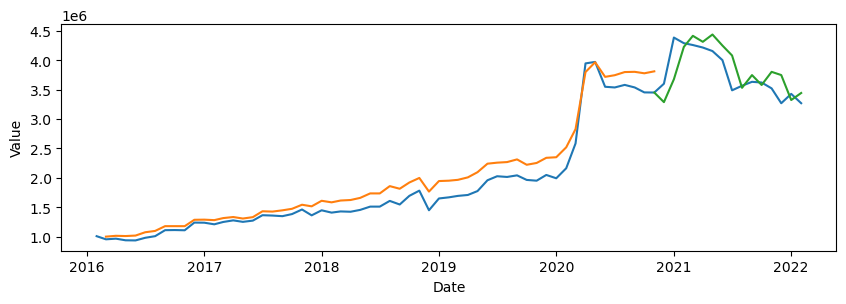

In [217]:
plot_sales, actual_fitted_sales = fitted_and_predicted_sales_xgboost(rfmodel, pred_growthrate_rf, retailEcommercesales, train_rf, test_rf)

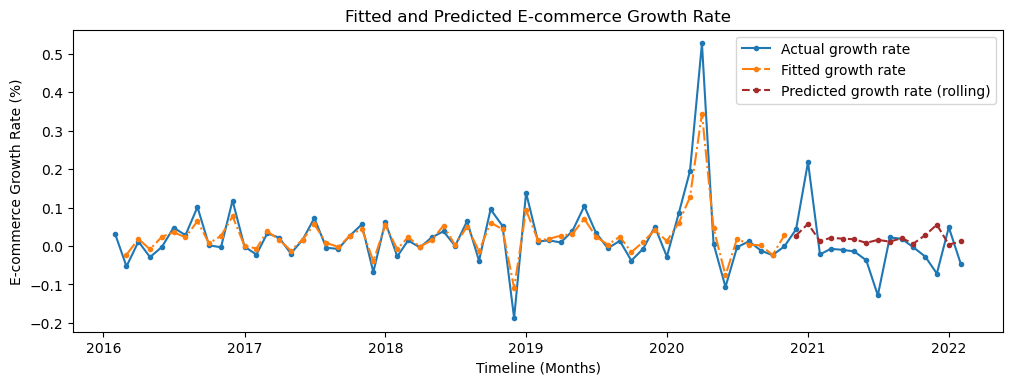

In [174]:
#### Growth Rate plot
plot_data = fitted_values_rf
plot_data.index = pd.to_datetime(plot_data.index)
fig1 = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(plot_data.iloc[:,0], marker='o', markersize=3, label="Actual growth rate")
plt.plot(plot_data.iloc[:,1], marker='o', markersize=3, label="Fitted growth rate", linestyle="-.")
plt.plot(plot_data.iloc[:,2], marker='o', markersize=3, label="Predicted growth rate (rolling)", linestyle="--", color="brown")
plt.gca().set(title="Fitted and Predicted E-commerce Growth Rate",
              xlabel="Timeline (Months)", ylabel="E-commerce Growth Rate (%)")
plt.xticks()
plt.legend()
plt.savefig('Ecommerce_RFGrowthRate.png')
plt.show()

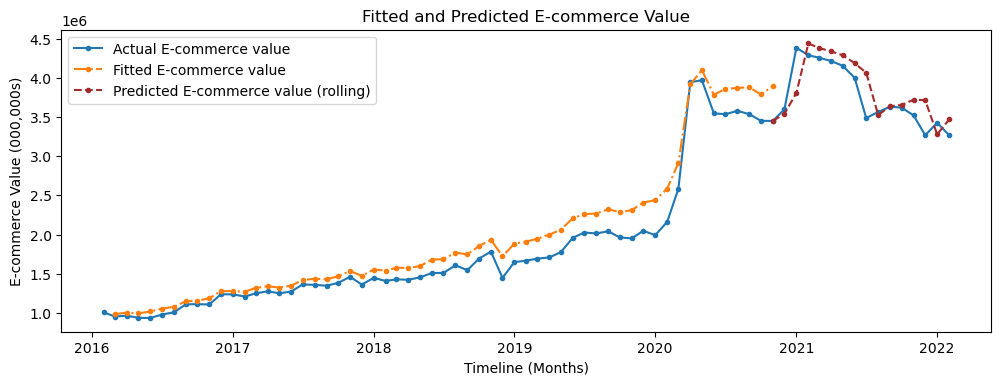

In [181]:
#### E-commerce Value
plot_data = actual_fitted_sales   
plot_data.index = pd.to_datetime(plot_data.index)
fig2 = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(plot_data.iloc[:,0], marker='o', markersize=3, label="Actual E-commerce value")
plt.plot(plot_data.iloc[:,1], marker='o', markersize=3, label="Fitted E-commerce value", linestyle="-.")
plt.plot(plot_data.iloc[:,2], marker='o', markersize=3, label="Predicted E-commerce value (rolling)", linestyle="--", color="brown")
plt.gca().set(title="Fitted and Predicted E-commerce Value",
              xlabel="Timeline (Months)", ylabel="E-commerce Value (000,000s)")
plt.xticks()
plt.legend()
plt.savefig('Ecommerce_RF_value.png')
plt.show()

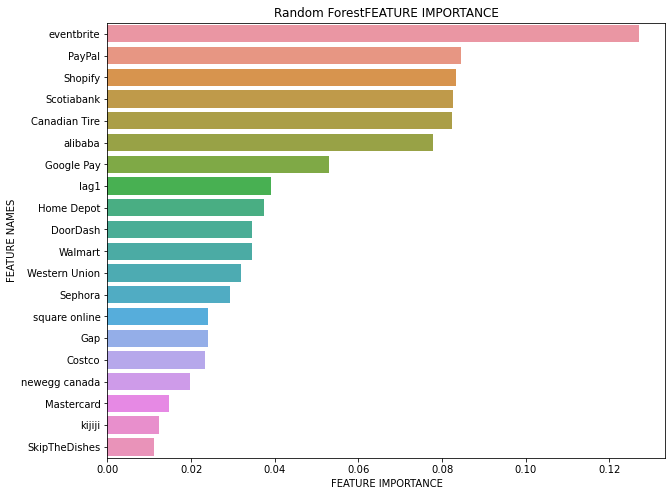

In [176]:
# features importance plot

plot_feature_importance(rfmodel.feature_importances_, X_rf.columns, 'Random Forest')

**CrossValidation Random forest**

*Inbuild library*

In [81]:
from sklearn.model_selection import GridSearchCV

def rf_cv(parameters):
    rfc = RandomForestRegressor()
    cvsearch = GridSearchCV(rfc,parameters,cv=5)
    cvsearch.fit(X_rf,y_rf.values.ravel())
    return(f'Best parameters are: {cvsearch.best_params_}')
    
    mean_score = cvsearch.cv_results_['mean_test_score']
    std_score = cvsearch.cv_results_['std_test_score']
    params = cvsearch.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,4)} + or -{round(std,4)} for the {params}')

rf_cv(parameters = {
    "n_estimators":[i for i in range(X_rf.shape[1])],
    "max_depth":[i for i in range(X_rf.shape[1])]
    
})

"Best parameters are: {'max_depth': 20, 'n_estimators': 20}"

*User-defined*

In [207]:
def cv_model_rf(kfolds=5,train_set=train_rf,dependent_var='Growth_rate',n_trees =100):
    entry_count = int(train_set.shape[0]/kfolds)
    train = train_set.iloc[:entry_count,:]
    error = 0

    for i in range(entry_count,len(train_set),entry_count):
        test = train_set.iloc[i:i+entry_count,:]
        #rfmodel_temp = modeltype(train, dependent_var)
        pred_growthrate_rf_temp = rolling_prediction_RF(train, test,dependent_var,n_trees)
        pred_growthrate_rf_temp = pred_growthrate_rf_temp.rename(columns = {0:dependent_var})
        #train_df = pd.merge(test_new,pred_growthrate_rf_temp,left_index=True, right_index = True)
        train = train.append(test)
        error = error + np.sqrt(np.mean(pow(pred_growthrate_rf_temp[dependent_var] - test[dependent_var],2)))
    return error/(kfolds-1)

In [208]:
#ecommerce RF model validation

cv_model_rf(kfolds=5,train_set=train_rf,dependent_var='Growth_rate',n_trees =100)

0.09426768098797883

In [209]:
# cross validation for trees between 100 and 1000 in RF

kfolds = 5
min_trees = 100
max_trees = 1000
step_size = 100
rf_cv_df = pd.DataFrame(columns=["Num of trees", "Cross validation error"])
for i, num_trees in enumerate(range(min_trees, max_trees+1, step_size)):
    error = cv_model_rf(kfolds, train_rf, 'Growth_rate', n_trees=num_trees)
    rf_cv_df.loc[i, "Num of trees"] = num_trees
    rf_cv_df.loc[i, "Cross validation error"] = error

print(rf_cv_df[rf_cv_df['Cross validation error'] == rf_cv_df['Cross validation error'].min()])

  Num of trees Cross validation error
0          100               0.089936


### ML Model fitting with PCA 


#### XGBoost with PCA

In [85]:
def apply_pca(predictors_data, n_comp):
    pca = PCA(n_components=n_comp)
    pca.fit(predictors_data)
    components = pd.DataFrame(pca.fit_transform(predictors_data))
    components.index = predictors_data.index
    return components, sum(pca.explained_variance_ratio_)

In [215]:
xgboost_predictors, xgboost_response = get_lag1_data(retailEcommercesales_ts, ecommerce_keyword_ts)

In [216]:
temp_predictor = xgboost_predictors.loc[:, ~xgboost_predictors.columns.isin(['lag1'])]
components, var = apply_pca(xgboost_predictors,n_comp=20)
print(var)

0.970305280907852


In [217]:
# XGBoost
xgboost_predictors = make_predictors_df(xgboost_predictors['lag1'], components)

# train test split
train_xg, test_xg, _ = ts_train_test_split(xgboost_response, xgboost_predictors, test_size=0.2)
train_xg.shape

(57, 22)

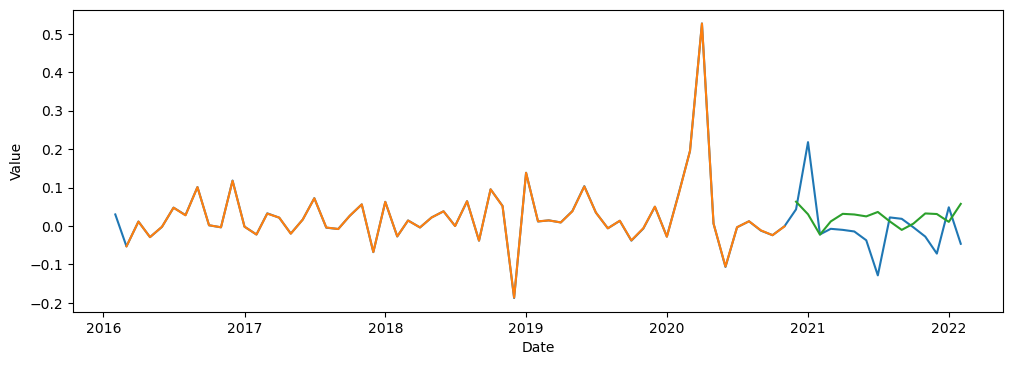

Prediction error: 292522.99307641195


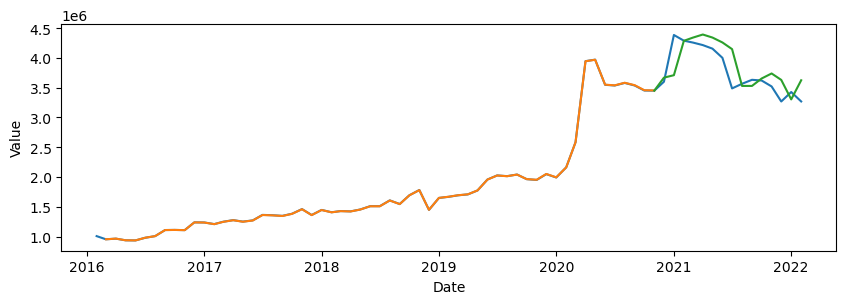

(292522.99307641195,
             Actual EcommerceSales  Fitted EcommerceSales  \
 Date                                                       
 2016-02-01                1006610                    NaN   
 2016-03-01                 953186          953568.494836   
 2016-04-01                 964279          964492.332769   
 2016-05-01                 936366          936586.864912   
 2016-06-01                 934274          934716.538819   
 ...                           ...                    ...   
 2021-10-01                3619531                    NaN   
 2021-11-01                3519879                    NaN   
 2021-12-01                3267226                    NaN   
 2022-01-01                3426323                    NaN   
 2022-02-01                3267756                    NaN   
 
             Predicted EcommerceSales  
 Date                                  
 2016-02-01                       NaN  
 2016-03-01                       NaN  
 2016-04-01             

In [219]:
# fit model and get fitted growth rate
xg_model = xgboost_modelfit(train_xg, dependent_var='Growth_rate')

X_xg, y_xg = train_xg.loc[:, ~train_xg.columns.isin(['Growth_rate'])], train_xg[['Growth_rate']]
fitted_growthRate_xg = xg_model.predict(X_xg)
fitted_growthRate_xg = pd.DataFrame(fitted_growthRate_xg, columns={'Fitted Ecommerce_GrowthRate'})
fitted_growthRate_xg.index = train_xg.index

# Rolling prediction of growth rate
pred_growthrate_xg = rolling_prediction_xgboost(train_xg, test_xg, dependent_var='Growth_rate')


fitted_values_xg = pd.DataFrame({'Ecommerce_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                'Fitted Value': fitted_growthRate_xg.squeeze(),
                                'Predicted Value': pred_growthrate_xg.squeeze()})
plot_df(fitted_values_xg, width=12, height=4)


fitted_and_predicted_sales_xgboost(xg_model, pred_growthrate_xg, retailEcommercesales, train_xg, test_xg)

### Random forest after PCA

In [224]:
# RF after PCA

# get data for random forest
rf_predictors, rf_response_var = get_lag1_data(retailEcommercesales_ts, ecommerce_keyword_ts)

temp_predcitors_rf = rf_predictors.loc[:, ~rf_predictors.columns.isin(['lag1'])]
components, var = apply_pca(temp_predcitors_rf, n_comp=20)
rf_predictors = make_predictors_df(rf_predictors['lag1'], components)
print(var)

# train test split
train_rf, test_rf, _ = ts_train_test_split(rf_response_var, rf_predictors, test_size=0.2)
train_rf.shape

0.9704519419002147


(57, 22)

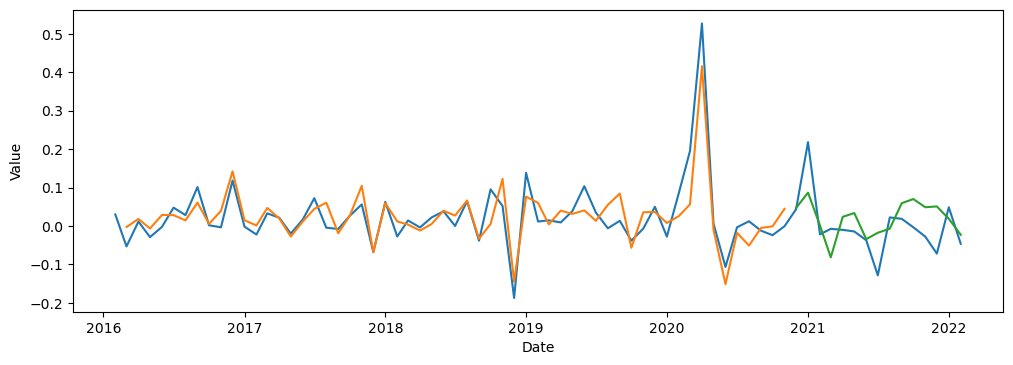

Prediction error: 313981.4272357983


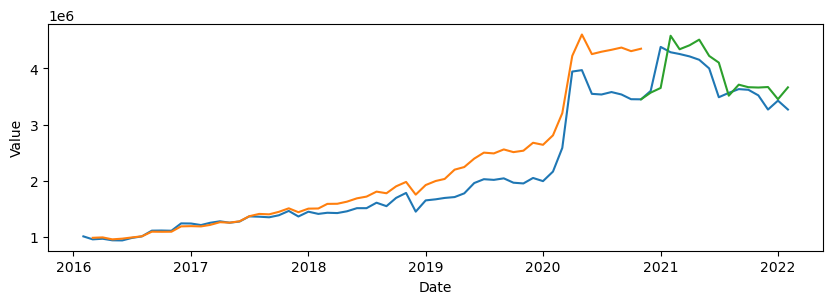

(313981.4272357983,
             Actual EcommerceSales  Fitted EcommerceSales  \
 Date                                                       
 2016-02-01                1006610                    NaN   
 2016-03-01                 953186          981176.924963   
 2016-04-01                 964279          988269.854512   
 2016-05-01                 936366          953396.471483   
 2016-06-01                 934274          965955.177629   
 ...                           ...                    ...   
 2021-10-01                3619531                    NaN   
 2021-11-01                3519879                    NaN   
 2021-12-01                3267226                    NaN   
 2022-01-01                3426323                    NaN   
 2022-02-01                3267756                    NaN   
 
             Predicted EcommerceSales  
 Date                                  
 2016-02-01                       NaN  
 2016-03-01                       NaN  
 2016-04-01              

In [228]:
# fit model
rfmodel = randomForest_modelfit(train_rf, dependent_var='Growth_rate', n_trees=300)

# fitted growth rate
X_rf, y_rf = train_rf.loc[:, ~train_rf.columns.isin(['Growth_rate'])], train_rf[['Growth_rate']]
fitted_growthRate_rf = rfmodel.predict(X_rf)
fitted_growthRate_rf = pd.DataFrame(fitted_growthRate_rf, columns={'Fitted Ecommerce_GrowthRate'})
fitted_growthRate_rf.index = train_rf.index

# Rolling prediction of growth rate
pred_growthrate_rf = rolling_prediction_RF(train_rf, test_rf, dependent_var='Growth_rate', n_trees=300)


fitted_values_rf = pd.DataFrame({'Ecommerce_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                'Fitted Value': fitted_growthRate_rf.squeeze(),
                                'Predicted Value': pred_growthrate_rf.squeeze()})
plot_df(fitted_values_lasso, width=12, height=4)

fitted_and_predicted_sales_xgboost(rfmodel, pred_growthrate_rf, retailEcommercesales, train_rf, test_rf)